# import all libraries and load datasets

In [503]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import statsmodels.tsa.seasonal as smt
import numpy as np 
import pandas as pd 
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import plotly
import tensorflow as tf
from math import sqrt
print(tf.__version__)

2.3.1


# Functions

In [884]:
def making_scaled_training_val_test_data(df,train_start_num,val_start_num,test_start_num,test_end_num):
    train_start = train_start_num
    train_end = val_start_num
    train_data = df.loc[train_start:train_end-1]

    val_start = val_start_num
    val_end = test_start_num
    val_data = df.loc[val_start:val_end-1]

    test_start = test_start_num
    test_end = test_end_num
    test_data = df.loc[test_start:test_end-1]

    sc = MinMaxScaler()
    train_sc = sc.fit_transform(train_data)
    val_sc = sc.transform(val_data)
    test_sc = sc.transform(test_data) 
    return train_sc,val_sc,test_sc

def making_train_val(train_data,val_data,windows_size):
    X_train = []
    y_train = []
    X_val = []
    y_val = []

    for i in range(windows_size,train_data.shape[0]):
        X_train.append(train_data[i-windows_size:i])
        y_train.append(train_data[i][0])
    X_train,y_train = np.array(X_train),np.array(y_train)
  
    for i in range(windows_size,val_data.shape[0]):
        X_val.append(val_data[i-windows_size:i])
        y_val.append(val_data[i][0])
    X_val,y_val = np.array(X_val),np.array(y_val)
   
    return X_train,y_train,X_val,y_val

def making_test(test_data,windows_size):
    X_test = []
    y_test = []
    for i in range(windows_size,test_sc.shape[0]):
        X_test.append(test_data[i-windows_size:i])
        y_test.append(test_data[i][0])
    X_test,y_test = np.array(X_test),np.array(y_test) 
    return X_test,y_test

#Evaluation
def making_y_pred(model,X_test):
    y_pred= model.predict(X_test)
    y_pred=y_pred.ravel()
    return y_pred
def Eval(model,X_test,y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    rmse = sqrt(mse)
    r = r2_score(y_test,y_pred)
    print('MSE:',mse,' RMSE:',rmse, 'R^2 score:',r)
    return mse,rmse,r

def testset_plot(y_test,y_pred):
    plt.plot(y_test,c = 'r')
    plt.plot(y_pred,c = 'b')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('stock price')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

# Data preprocessing to make technical indicators

In [646]:
def Highlow_Openclose(dataset):
    dataset['H-L']=dataset['High']-dataset['Low']
    dataset['O-C']=dataset['Close']-dataset['Open']
#https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/standard-deviation
import math
def std_dev(dataset,days):
    n=days
    dataset['{} DAYS STD DEV'.format(days)]=0
    dataset['sq(C-MA)']=(dataset['Close']-dataset['{} DAYS MA'.format(n)])**2
    for i in range(len(dataset)):
        dataset['{} DAYS STD DEV'.format(n)].iloc[i]=math.sqrt(sum(dataset['sq(C-MA)'].iloc[i-n:i])/n)
    dataset.drop('sq(C-MA)', axis=1,inplace=True)
#https://www.investopedia.com/terms/m/movingaverage.asp
def MA(dataset,days):
    n=days
    dataset['{} DAYS MA'.format(n)]=0
    for i in range(len(dataset)):
        dataset['{} DAYS MA'.format(n)].iloc[i]=sum(dataset['Close'].iloc[i-n:i])/n
'''
'https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi'
The very first calculations for average gain and average loss are simple 14-period averages:

First Average Gain = Sum of Gains over the past 14 periods / 14.
First Average Loss = Sum of Losses over the past 14 periods / 14
The second, and subsequent, calculations are based on the prior averages and the current gain loss:

Average Gain = [(previous Average Gain) x 13 + current Gain] / 14.
Average Loss = [(previous Average Loss) x 13 + current Loss] / 14.
'''

def RSI(dataset):
    dataset['Change'] = dataset['Close'].diff()
    dataset['Gain']=dataset['Change'].where(dataset['Change']>0,0.0)
    dataset['Loss']=abs(dataset['Change'].where(dataset['Change']<0,0.0))
    dataset['AG']=0
    dataset['AL']=0
    for i in range(len(dataset)):
        dataset['AG'].iloc[i]=sum(dataset['Gain'].iloc[i-14:i])/14
        dataset['AL'].iloc[i]=sum(dataset['Loss'].iloc[i-14:i])/14
    dataset['RS']=dataset['AG']/dataset['AL']
    dataset['RSI']=100-100/(1+dataset['RS'])
    dataset.drop(['Change','Gain','Loss','AG','AL','RS'],axis=1,inplace=True)
#https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
def EMA(dataset,days):
    dataset['{} DAYS EMA'.format(days)]=dataset['Close'].ewm(span=days,adjust=False).mean()
def MACD(dataset,day1=12,day2=26):
    EMA(dataset,day1)
    EMA(dataset,day2)
    dataset['MACD']=dataset['{} DAYS EMA'.format(day1)]-dataset['{} DAYS EMA'.format(day2)]
    dataset.drop(columns=['{} DAYS EMA'.format(day1),'{} DAYS EMA'.format(day2)],axis=1,inplace=True)


df,df2,df3=pd.read_csv("MSFT.csv"), pd.read_csv("AMD.csv"),pd.read_csv("NVDA.csv")
Highlow_Openclose(df)
MA(df,7)
MA(df,14)
MA(df,21)
std_dev(df,7)
EMA(df,10)
EMA(df,20)
RSI(df)   
MACD(df)
Highlow_Openclose(df2)
MA(df2,7)
MA(df2,14)
MA(df2,21)
std_dev(df2,7)
EMA(df2,10)
EMA(df2,20)
RSI(df2)   
MACD(df2)
Highlow_Openclose(df3)
MA(df3,7)
MA(df3,14)
MA(df3,21)
std_dev(df3,7)
EMA(df3,10)
EMA(df3,20)
RSI(df3)   
MACD(df3)
MSFT=df.copy()
AMD=df2.copy()
NVDA=df3.copy()

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCo

In [648]:
MSFT.to_csv('MSFT_indicators.csv',index=False)
AMD.to_csv('AMD_indicators.csv',index=False)
NVDA.to_csv('NVDA_indicators.csv',index=False)

In [696]:
NVDA

,Date,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,10 DAYS EMA,20 DAYS EMA,RSI,MACD
0,1999-01-22,1.750000,1.953125,1.552083,1.640625,1.508857,67867200.0,0.401042,-0.109375,0.000000,0.000000,0.000000,0.000000,1.640625,1.640625,NaN,0.000000
1,1999-01-25,1.770833,1.833333,1.640625,1.812500,1.666928,12762000.0,0.192708,0.041667,0.000000,0.000000,0.000000,0.000000,1.671875,1.656994,NaN,0.013711
2,1999-01-26,1.833333,1.869792,1.645833,1.671875,1.537597,8580000.0,0.223958,-0.161458,0.000000,0.000000,0.000000,0.000000,1.671875,1.658411,NaN,0.013079
3,1999-01-27,1.677083,1.718750,1.583333,1.666667,1.532807,6109200.0,0.135417,-0.010417,0.000000,0.000000,0.000000,0.000000,1.670928,1.659198,NaN,0.012019
4,1999-01-28,1.666667,1.677083,1.651042,1.661458,1.528017,5688000.0,0.026042,-0.005208,0.000000,0.000000,0.000000,0.000000,1.669206,1.659413,NaN,0.010636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,2020-11-13,545.090027,546.750000,522.369995,531.880005,531.880005,8657800.0,24.380005,-13.210022,547.381426,531.757145,536.220476,33.304724,536.543296,536.106889,49.028108,1.627440
5492,2020-11-16,526.900024,545.979980,526.239990,540.609985,540.609985,10344400.0,19.739990,13.709961,544.539995,532.202144,534.938572,31.017782,537.282694,536.535755,51.183731,1.831262
5493,2020-11-17,542.099976,543.849976,532.150024,536.890015,536.890015,7800700.0,11.699951,-5.209961,540.855704,532.540715,534.374285,25.591824,537.211298,536.569494,50.905753,1.673332
5494,2020-11-18,538.609985,544.229980,527.400024,537.150024,537.150024,12773100.0,16.829956,-1.459961,534.342852,534.812860,534.230477,13.129894,537.200157,536.624783,56.779918,1.551271


In [649]:
MSFT_corr=MSFT.corr()
AMD_corr=AMD.corr()
NVDA_corr=NVDA.corr()

<Figure size 1080x648 with 0 Axes>

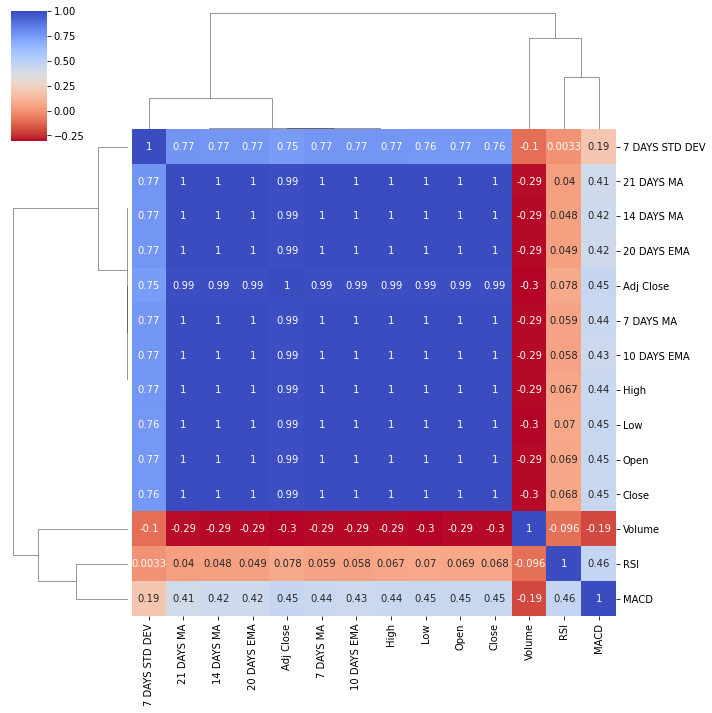

In [7]:
import seaborn as sns
plt.figure(figsize=(15,9))
sns.clustermap(MSFT_corr,annot=True,cmap='coolwarm_r')

<Figure size 1080x648 with 0 Axes>

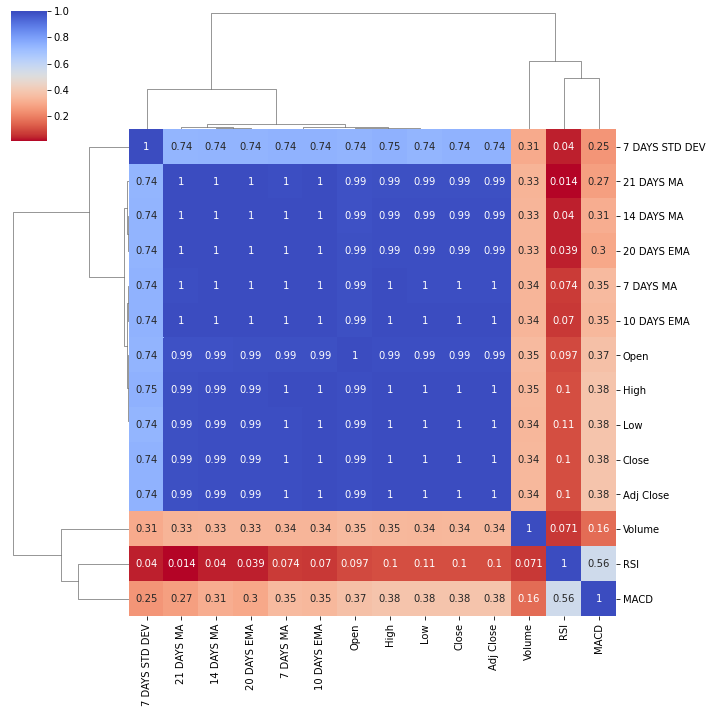

In [8]:
import seaborn as sns
plt.figure(figsize=(15,9))
sns.clustermap(AMD_corr,annot=True,cmap='coolwarm_r')

<Figure size 1080x648 with 0 Axes>

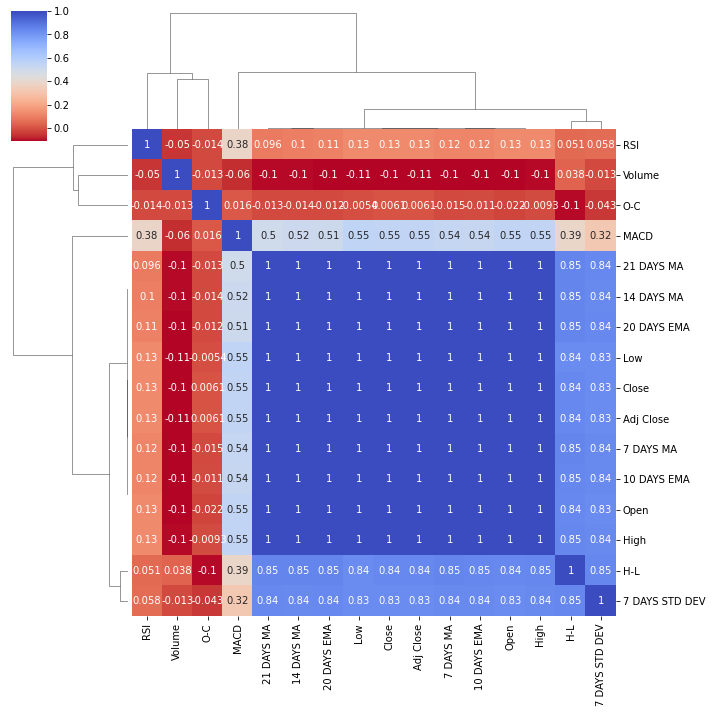

In [650]:
import seaborn as sns
plt.figure(figsize=(15,9))
sns.clustermap(NVDA_corr,annot=True,cmap='coolwarm_r')

# Prediction

## Baseline

### Linear

#### AMD

In [714]:
df_AMD=pd.read_csv("AMD_indicators.csv")
df_AMD_picked = df_AMD[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']] # Picking the features with high correlation
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)

In [715]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

model_linear_amd = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_linear_amd.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_linear_amd = model_linear_amd.fit(X_train_amd,y_train_amd, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
140/140 [==============================] - 0s 458us/step - loss: 0.0409 - mae: 0.2456
Epoch 2/100
140/140 [==============================] - 0s 443us/step - loss: 0.0368 - mae: 0.2303
Epoch 3/100
140/140 [==============================] - 0s 429us/step - loss: 0.0332 - mae: 0.2162
Epoch 4/100
140/140 [==============================] - 0s 415us/step - loss: 0.0299 - mae: 0.2030
Epoch 5/100
140/140 [==============================] - 0s 407us/step - loss: 0.0270 - mae: 0.1907
Epoch 6/100
140/140 [==============================] - 0s 407us/step - loss: 0.0243 - mae: 0.1790
Epoch 7/100
140/140 [==============================] - 0s 407us/step - loss: 0.0218 - mae: 0.1681
Epoch 8/100
140/140 [==============================] - 0s 422us/step - loss: 0.0196 - mae: 0.1581
Epoch 9/100
140/140 [==============================] - 0s 407us/step - loss: 0.0177 - mae: 0.1491
Epoch 10/100
140/140 [==============================] - 0s 415us/step - loss: 0.0161 - mae: 0.1410
Epoch 11/100
140/14

140/140 [==============================] - 0s 415us/step - loss: 0.0234 - mae: 0.1530
Epoch 83/100
140/140 [==============================] - 0s 428us/step - loss: 0.0020 - mae: 0.0439
Epoch 84/100
140/140 [==============================] - 0s 436us/step - loss: 0.0371 - mae: 0.1987
Epoch 85/100
140/140 [==============================] - 0s 443us/step - loss: 0.0144 - mae: 0.1267
Epoch 86/100
140/140 [==============================] - 0s 428us/step - loss: 0.0371 - mae: 0.1963
Epoch 87/100
140/140 [==============================] - 0s 422us/step - loss: 0.0986 - mae: 0.3378
Epoch 88/100
140/140 [==============================] - 0s 427us/step - loss: 0.0717 - mae: 0.2858
Epoch 89/100
140/140 [==============================] - 0s 422us/step - loss: 0.2506 - mae: 0.5388
Epoch 90/100
140/140 [==============================] - 0s 415us/step - loss: 0.2110 - mae: 0.4951
Epoch 91/100
140/140 [==============================] - 0s 415us/step - loss: 0.0805 - mae: 0.3237
Epoch 92/100
140/140 [=

(1e-05, 10.0, 0.0, 0.011)

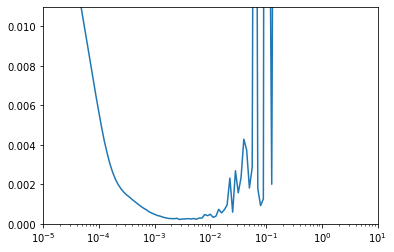

In [716]:
plt.semilogx(history_linear_amd.history["lr"], history_linear_amd.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [717]:
model_linear_amd = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

model_linear_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'mean_squared_error')

history_linear_amd = model_linear_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0233
Epoch 2/100
70/70 [==============================] - 0s 686us/step - loss: 0.0065 - val_loss: 0.0146
Epoch 3/100
70/70 [==============================] - 0s 629us/step - loss: 0.0050 - val_loss: 0.0117
Epoch 4/100
70/70 [==============================] - 0s 672us/step - loss: 0.0041 - val_loss: 0.0088
Epoch 5/100
70/70 [==============================] - 0s 629us/step - loss: 0.0035 - val_loss: 0.0075
Epoch 6/100
70/70 [==============================] - 0s 615us/step - loss: 0.0031 - val_loss: 0.0068
Epoch 7/100
70/70 [==============================] - 0s 601us/step - loss: 0.0029 - val_loss: 0.0060
Epoch 8/100
70/70 [==============================] - 0s 615us/step - loss: 0.0026 - val_loss: 0.0056
Epoch 9/100
70/70 [==============================] - 0s 701us/step - loss: 0.0024 - val_loss: 0.0050
Epoch 10/100
70/70 [==============================] - 0s 643us/step - loss: 0.0023 - val_loss

Epoch 77/100
70/70 [==============================] - 0s 586us/step - loss: 2.6275e-04 - val_loss: 1.6521e-04
Epoch 78/100
70/70 [==============================] - 0s 586us/step - loss: 2.7353e-04 - val_loss: 1.5138e-04
Epoch 79/100
70/70 [==============================] - 0s 601us/step - loss: 2.6492e-04 - val_loss: 1.6386e-04
Epoch 80/100
70/70 [==============================] - 0s 586us/step - loss: 2.6863e-04 - val_loss: 1.7520e-04
Epoch 81/100
70/70 [==============================] - 0s 586us/step - loss: 2.7600e-04 - val_loss: 1.7455e-04
Epoch 82/100
70/70 [==============================] - 0s 615us/step - loss: 2.8517e-04 - val_loss: 1.6429e-04
Epoch 83/100
70/70 [==============================] - 0s 601us/step - loss: 2.6210e-04 - val_loss: 1.6562e-04
Epoch 84/100
70/70 [==============================] - 0s 601us/step - loss: 2.5471e-04 - val_loss: 1.2705e-04
Epoch 85/100
70/70 [==============================] - 0s 600us/step - loss: 2.4555e-04 - val_loss: 1.3196e-04
Epoch 86/1

In [718]:
model_linear_amd.summary()

Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 121       
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

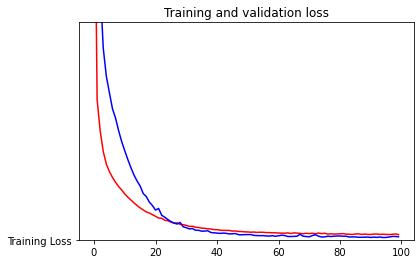

In [719]:
%matplotlib inline
loss_linear_amd=history_linear_amd.history['loss']
val_loss_linear_amd=history_linear_amd.history['val_loss']

epochs=range(len(loss_linear_amd)) 

plt.plot(epochs, loss_linear_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_linear_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [720]:

y_pred_linear_amd=making_y_pred(model_linear_amd,X_test_linear_amd)
mse_linear_amd,rmase_linear_amd,r_linear_amd=Eval(model_linear_amd,X_test_linear_amd,y_test_linear_amd,y_pred_linear_amd)

MSE: 0.0004870442191935928  RMSE: 0.02206907834943709 R^2 score: 0.9829180813798243


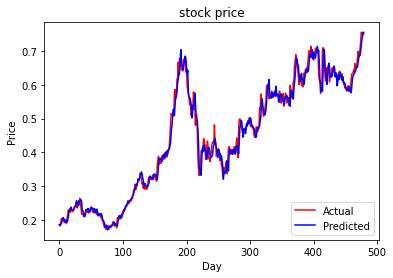

In [721]:
testset_plot(y_test_linear_amd,y_pred_linear_amd)

#### MSFT

In [722]:
df_MSFT=pd.read_csv("MSFT_indicators.csv")
df_MSFT_picked = df_MSFT[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']] 
windows_size=20

train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_MSFT_picked,2000,7500,8000,8500)
X_train_msft,y_train_msft,X_val_msft,y_val_msft=making_train_val(train_sc,val_sc,windows_size)

In [723]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

model_linear_msft = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_linear_msft.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_linear_msft = model_linear_msft.fit(X_train_msft,y_train_msft, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 0s 477us/step - loss: 0.0483 - mae: 0.2894
Epoch 2/100
172/172 [==============================] - 0s 466us/step - loss: 0.0331 - mae: 0.2316
Epoch 3/100
172/172 [==============================] - 0s 471us/step - loss: 0.0220 - mae: 0.1796
Epoch 4/100
172/172 [==============================] - 0s 466us/step - loss: 0.0148 - mae: 0.1400
Epoch 5/100
172/172 [==============================] - 0s 466us/step - loss: 0.0109 - mae: 0.1156
Epoch 6/100
172/172 [==============================] - 0s 466us/step - loss: 0.0091 - mae: 0.1038
Epoch 7/100
172/172 [==============================] - 0s 477us/step - loss: 0.0083 - mae: 0.0989
Epoch 8/100
172/172 [==============================] - 0s 483us/step - loss: 0.0078 - mae: 0.0960
Epoch 9/100
172/172 [==============================] - 0s 489us/step - loss: 0.0073 - mae: 0.0932
Epoch 10/100
172/172 [==============================] - 0s 483us/step - loss: 0.0068 - mae: 0.0902
Epoch 11/100
172/17

172/172 [==============================] - 0s 500us/step - loss: 0.0314 - mae: 0.1955
Epoch 83/100
172/172 [==============================] - 0s 483us/step - loss: 0.0222 - mae: 0.1426
Epoch 84/100
172/172 [==============================] - 0s 483us/step - loss: 0.0184 - mae: 0.1323
Epoch 85/100
172/172 [==============================] - 0s 506us/step - loss: 0.0491 - mae: 0.2337
Epoch 86/100
172/172 [==============================] - 0s 489us/step - loss: 0.0755 - mae: 0.3048
Epoch 87/100
172/172 [==============================] - 0s 477us/step - loss: 0.0216 - mae: 0.1543
Epoch 88/100
172/172 [==============================] - 0s 471us/step - loss: 0.2156 - mae: 0.4669
Epoch 89/100
172/172 [==============================] - 0s 506us/step - loss: 0.0050 - mae: 0.0697
Epoch 90/100
172/172 [==============================] - 0s 500us/step - loss: 0.1983 - mae: 0.4973
Epoch 91/100
172/172 [==============================] - 0s 466us/step - loss: 0.8829 - mae: 1.2454
Epoch 92/100
172/172 [=

(1e-05, 10.0, 0.0, 0.011)

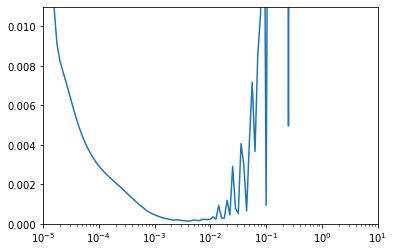

In [724]:
plt.semilogx(history_linear_msft.history["lr"], history_linear_msft.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [725]:
model_linear_msft = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

model_linear_msft.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'mean_squared_error')

history_linear_msft = model_linear_msft.fit(X_train_msft,y_train_msft ,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0795 - val_loss: 0.0454
Epoch 2/100
86/86 [==============================] - 0s 582us/step - loss: 0.0158 - val_loss: 0.0287
Epoch 3/100
86/86 [==============================] - 0s 582us/step - loss: 0.0112 - val_loss: 0.0190
Epoch 4/100
86/86 [==============================] - 0s 582us/step - loss: 0.0080 - val_loss: 0.0132
Epoch 5/100
86/86 [==============================] - 0s 570us/step - loss: 0.0058 - val_loss: 0.0115
Epoch 6/100
86/86 [==============================] - 0s 570us/step - loss: 0.0045 - val_loss: 0.0105
Epoch 7/100
86/86 [==============================] - 0s 570us/step - loss: 0.0036 - val_loss: 0.0105
Epoch 8/100
86/86 [==============================] - 0s 582us/step - loss: 0.0031 - val_loss: 0.0113
Epoch 9/100
86/86 [==============================] - 0s 570us/step - loss: 0.0027 - val_loss: 0.0106
Epoch 10/100
86/86 [==============================] - 0s 582us/step - loss: 0.0025 - val_loss

86/86 [==============================] - 0s 568us/step - loss: 2.4973e-04 - val_loss: 4.6437e-04
Epoch 79/100
86/86 [==============================] - 0s 617us/step - loss: 2.6085e-04 - val_loss: 5.1712e-04
Epoch 80/100
86/86 [==============================] - 0s 605us/step - loss: 2.4708e-04 - val_loss: 3.6453e-04
Epoch 81/100
86/86 [==============================] - 0s 570us/step - loss: 2.6306e-04 - val_loss: 3.8912e-04
Epoch 82/100
86/86 [==============================] - 0s 582us/step - loss: 2.3861e-04 - val_loss: 9.5816e-04
Epoch 83/100
86/86 [==============================] - 0s 565us/step - loss: 2.3336e-04 - val_loss: 4.7991e-04
Epoch 84/100
86/86 [==============================] - 0s 582us/step - loss: 2.3822e-04 - val_loss: 6.5174e-04
Epoch 85/100
86/86 [==============================] - 0s 570us/step - loss: 2.2983e-04 - val_loss: 4.8247e-04
Epoch 86/100
86/86 [==============================] - 0s 570us/step - loss: 2.3017e-04 - val_loss: 4.3161e-04
Epoch 87/100
86/86 [===

In [726]:
model_linear_msft.summary()

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 121       
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

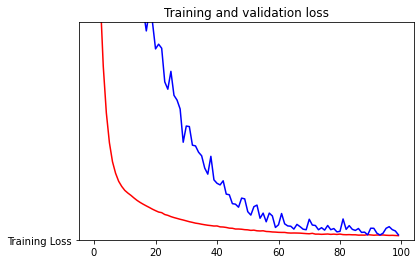

In [727]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_linear_msft=history_linear_msft.history['loss']
val_loss_linear_msft=history_linear_msft.history['val_loss']

epochs=range(len(loss_linear_msft)) 

plt.plot(epochs, loss_linear_msft, 'r', "Training Loss")
plt.plot(epochs, val_loss_linear_msft, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [728]:
X_test_msft,y_test_msft=making_test(test_sc,20)

In [729]:
y_pred_linear_msft=making_y_pred(model_linear_msft,X_test_msft)

In [730]:
mse_linear_msft,rmse_linear_msft,r_linear_msft=Eval(model_linear_msft,X_test_msft,y_test_msft,y_pred_linear_msft)

MSE: 0.0014754534553838429  RMSE: 0.038411631771949534 R^2 score: 0.9841318304935762


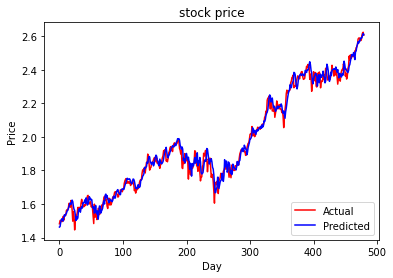

In [731]:
testset_plot(y_test_msft,y_pred_linear_msft)

#### NVDA

In [732]:
df_nvda=pd.read_csv("NVDA_indicators.csv")
df_nvda_picked = df_nvda[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']] 
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_nvda_picked,1500,4500,5000,5495)
X_train_nvda,y_train_nvda,X_val_nvda,y_val_nvda=making_train_val(train_sc,val_sc,windows_size)

In [733]:
model_linear_nvda = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_linear_nvda.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history_linear_nvda = model_linear_nvda.fit(X_train_nvda,y_train_nvda, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 0s 458us/step - loss: 0.0135 - mae: 0.1148
Epoch 2/100
94/94 [==============================] - 0s 458us/step - loss: 0.0130 - mae: 0.1134
Epoch 3/100
94/94 [==============================] - 0s 447us/step - loss: 0.0126 - mae: 0.1120
Epoch 4/100
94/94 [==============================] - 0s 468us/step - loss: 0.0121 - mae: 0.1106
Epoch 5/100
94/94 [==============================] - 0s 447us/step - loss: 0.0117 - mae: 0.1087
Epoch 6/100
94/94 [==============================] - 0s 458us/step - loss: 0.0112 - mae: 0.1069
Epoch 7/100
94/94 [==============================] - 0s 458us/step - loss: 0.0106 - mae: 0.1045
Epoch 8/100
94/94 [==============================] - 0s 458us/step - loss: 0.0101 - mae: 0.1020
Epoch 9/100
94/94 [==============================] - 0s 447us/step - loss: 0.0095 - mae: 0.0993
Epoch 10/100
94/94 [==============================] - 0s 458us/step - loss: 0.0089 - mae: 0.0965
Epoch 11/100
94/94 [===================

94/94 [==============================] - 0s 468us/step - loss: 0.1218 - mae: 0.3661
Epoch 85/100
94/94 [==============================] - 0s 437us/step - loss: 0.0063 - mae: 0.0827
Epoch 86/100
94/94 [==============================] - 0s 447us/step - loss: 0.0016 - mae: 0.0423
Epoch 87/100
94/94 [==============================] - 0s 468us/step - loss: 0.0540 - mae: 0.2516
Epoch 88/100
94/94 [==============================] - 0s 458us/step - loss: 0.0930 - mae: 0.3262
Epoch 89/100
94/94 [==============================] - 0s 458us/step - loss: 0.0458 - mae: 0.2367
Epoch 90/100
94/94 [==============================] - 0s 447us/step - loss: 0.9000 - mae: 1.2684
Epoch 91/100
94/94 [==============================] - 0s 447us/step - loss: 0.4827 - mae: 0.8529
Epoch 92/100
94/94 [==============================] - 0s 447us/step - loss: 0.0274 - mae: 0.1717
Epoch 93/100
94/94 [==============================] - 0s 458us/step - loss: 0.0565 - mae: 0.2509
Epoch 94/100
94/94 [=======================

(1e-05, 10.0, 0.0, 0.011)

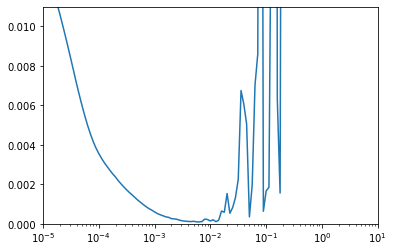

In [734]:
plt.semilogx(history_linear_nvda.history["lr"], history_linear_nvda.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [735]:
model_linear_nvda = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

model_linear_nvda.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.1), loss = 'mean_squared_error')

history_linear_nvda = model_linear_nvda.fit(X_train_nvda,y_train_nvda,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_nvda, y_val_nvda),verbose = 1)

Epoch 1/100
47/47 [==============================] - 0s 2ms/step - loss: 0.5731 - val_loss: 0.1740
Epoch 2/100
47/47 [==============================] - 0s 724us/step - loss: 0.0091 - val_loss: 0.2673
Epoch 3/100
47/47 [==============================] - 0s 703us/step - loss: 0.0024 - val_loss: 0.0694
Epoch 4/100
47/47 [==============================] - 0s 703us/step - loss: 0.0017 - val_loss: 0.0540
Epoch 5/100
47/47 [==============================] - 0s 703us/step - loss: 0.0011 - val_loss: 0.0396
Epoch 6/100
47/47 [==============================] - 0s 745us/step - loss: 8.2437e-04 - val_loss: 0.0330
Epoch 7/100
47/47 [==============================] - 0s 724us/step - loss: 5.9319e-04 - val_loss: 0.0237
Epoch 8/100
47/47 [==============================] - 0s 745us/step - loss: 4.5136e-04 - val_loss: 0.0200
Epoch 9/100
47/47 [==============================] - 0s 724us/step - loss: 3.9231e-04 - val_loss: 0.0177
Epoch 10/100
47/47 [==============================] - 0s 745us/step - loss: 3

47/47 [==============================] - 0s 681us/step - loss: 0.0042 - val_loss: 0.0600
Epoch 80/100
47/47 [==============================] - 0s 703us/step - loss: 0.0050 - val_loss: 0.0115
Epoch 81/100
47/47 [==============================] - 0s 724us/step - loss: 0.0077 - val_loss: 0.0345
Epoch 82/100
47/47 [==============================] - 0s 660us/step - loss: 0.0310 - val_loss: 1.5921
Epoch 83/100
47/47 [==============================] - 0s 703us/step - loss: 0.0480 - val_loss: 0.1128
Epoch 84/100
47/47 [==============================] - 0s 681us/step - loss: 0.0106 - val_loss: 0.0270
Epoch 85/100
47/47 [==============================] - 0s 703us/step - loss: 0.0025 - val_loss: 0.1041
Epoch 86/100
47/47 [==============================] - 0s 681us/step - loss: 0.0012 - val_loss: 0.0788
Epoch 87/100
47/47 [==============================] - 0s 703us/step - loss: 5.5368e-04 - val_loss: 0.0073
Epoch 88/100
47/47 [==============================] - 0s 681us/step - loss: 2.7715e-04 - va

In [736]:
model_linear_nvda.summary()

Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 121       
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

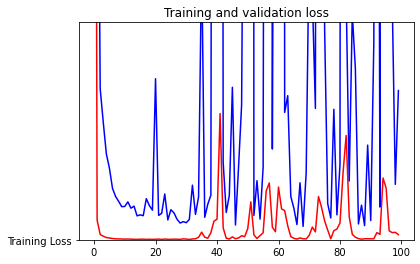

In [737]:
%matplotlib inline
loss_linear_nvda=history_linear_nvda.history['loss']
val_loss_linear_nvda=history_linear_nvda.history['val_loss']

epochs=range(len(loss_linear_nvda)) 

plt.plot(epochs, loss_linear_nvda, 'r', "Training Loss")
plt.plot(epochs, val_loss_linear_nvda, 'b', "Validation Loss")
plt.ylim([0,0.1])

plt.title('Training and validation loss')

In [738]:
X_test_nvda,y_test_nvda=making_test(test_sc,20)
y_pred_linear_nvda=making_y_pred(model_linear_nvda,X_test_nvda)
mse_linear_nvda,rmase_linear_nvda,r_linear_nvda=Eval(model_linear_nvda,X_test_nvda,y_test_nvda,y_pred_linear_nvda)

MSE: 0.16041815867797288  RMSE: 0.4005223572760613 R^2 score: 0.9253051850034573


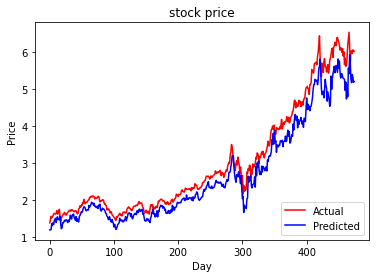

In [739]:
testset_plot(y_test_nvda,y_pred_linear_nvda)

### simple RNN

#### AMD

In [740]:
train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)

In [741]:
model_simpleRNN_amd = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[20, 6])
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_simpleRNN_amd.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_simpleRNN_amd = model_simpleRNN_amd.fit(X_train_amd,y_train_amd, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1416 - mae: 0.4356
Epoch 2/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1401 - mae: 0.4319
Epoch 3/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1385 - mae: 0.4277
Epoch 4/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1366 - mae: 0.4228
Epoch 5/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1346 - mae: 0.4174
Epoch 6/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1322 - mae: 0.4110
Epoch 7/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1295 - mae: 0.4039
Epoch 8/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1265 - mae: 0.3957
Epoch 9/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1231 - mae: 0.3862
Epoch 10/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1193 - mae: 0.3756
Epoch 11/100
140/140 [=================

140/140 [==============================] - 0s 2ms/step - loss: 2.2722e-04 - mae: 0.0130
Epoch 86/100
140/140 [==============================] - 0s 2ms/step - loss: 2.2902e-04 - mae: 0.0132
Epoch 87/100
140/140 [==============================] - 0s 2ms/step - loss: 2.3067e-04 - mae: 0.0132
Epoch 88/100
140/140 [==============================] - 0s 2ms/step - loss: 2.3052e-04 - mae: 0.0133
Epoch 89/100
140/140 [==============================] - 0s 2ms/step - loss: 2.3607e-04 - mae: 0.0135
Epoch 90/100
140/140 [==============================] - 0s 2ms/step - loss: 2.3074e-04 - mae: 0.0133
Epoch 91/100
140/140 [==============================] - 0s 2ms/step - loss: 2.3393e-04 - mae: 0.0136
Epoch 92/100
140/140 [==============================] - 0s 2ms/step - loss: 2.3754e-04 - mae: 0.0137
Epoch 93/100
140/140 [==============================] - 0s 2ms/step - loss: 2.4444e-04 - mae: 0.0140
Epoch 94/100
140/140 [==============================] - 0s 2ms/step - loss: 2.3872e-04 - mae: 0.0138
Epo

(1e-05, 10.0, 0.0, 0.011)

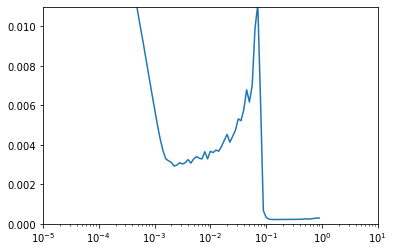

In [742]:
plt.semilogx(history_simpleRNN_amd.history["lr"], history_simpleRNN_amd.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [743]:
model_simpleRNN_amd = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[20, 6])
])

model_simpleRNN_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_simpleRNN_amd = model_simpleRNN_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 0s 4ms/step - loss: 0.0562 - val_loss: 0.0169
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0178
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0179
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0160
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0188 - val_loss: 0.0132
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0110
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0089
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0076
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0063
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0054
Epoch 11/

70/70 [==============================] - 0s 2ms/step - loss: 4.5228e-04 - val_loss: 2.3089e-04
Epoch 81/100
70/70 [==============================] - 0s 2ms/step - loss: 4.5077e-04 - val_loss: 2.2266e-04
Epoch 82/100
70/70 [==============================] - 0s 2ms/step - loss: 4.5049e-04 - val_loss: 2.2880e-04
Epoch 83/100
70/70 [==============================] - 0s 2ms/step - loss: 4.5112e-04 - val_loss: 2.1810e-04
Epoch 84/100
70/70 [==============================] - 0s 2ms/step - loss: 4.5000e-04 - val_loss: 2.3033e-04
Epoch 85/100
70/70 [==============================] - 0s 2ms/step - loss: 4.4913e-04 - val_loss: 2.2790e-04
Epoch 86/100
70/70 [==============================] - 0s 2ms/step - loss: 4.4940e-04 - val_loss: 2.2762e-04
Epoch 87/100
70/70 [==============================] - 0s 2ms/step - loss: 4.4989e-04 - val_loss: 2.2534e-04
Epoch 88/100
70/70 [==============================] - 0s 2ms/step - loss: 4.4982e-04 - val_loss: 2.1789e-04
Epoch 89/100
70/70 [=====================

In [744]:
model_simpleRNN_amd.summary()

Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

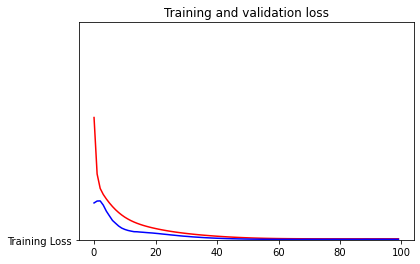

In [745]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_simpleRNN_amd=history_simpleRNN_amd.history['loss']
val_loss_simpleRNN_amd=history_simpleRNN_amd.history['val_loss']

epochs=range(len(loss)) 

plt.plot(epochs, loss_simpleRNN_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_simpleRNN_amd, 'b', "Validation Loss")
plt.ylim([0,0.1])

plt.title('Training and validation loss')

In [746]:
X_test_amd,y_test_amd=making_test(test_sc,20)
y_pred_simpleRNN_amd=making_y_pred(model_simpleRNN_amd,X_test_amd)

In [747]:
mse_simpleRNN_amd,rmse_simpleRNN_amd,r_simpleRNN_amd=Eval(model_simpleRNN_amd,X_test_amd,y_test_amd,y_pred_simpleRNN_amd)

MSE: 0.000569187756070027  RMSE: 0.023857656131104476 R^2 score: 0.9800370920223899


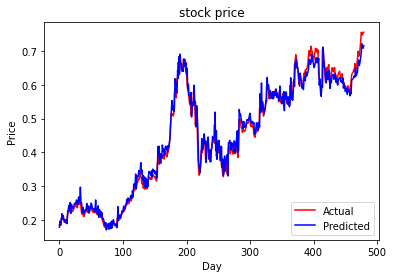

In [748]:
testset_plot(y_test_amd,y_pred_simpleRNN_amd)

#### MSFT

In [749]:
df_MSFT=pd.read_csv("MSFT_indicators.csv")
df_MSFT_picked = df_MSFT[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']] 
windows_size=20
  
train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_MSFT_picked,2000,7500,8000,8500)
X_train_msft,y_train_msft,X_val_msft,y_val_msft=making_train_val(train_sc,val_sc,windows_size)

In [750]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

model_simpleRNN_msft = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_simpleRNN_msft.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_simpleRNN_msft = model_simpleRNN_msft.fit(X_train_msft,y_train_msft, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 0s 477us/step - loss: 0.1952 - mae: 0.5503
Epoch 2/100
172/172 [==============================] - 0s 454us/step - loss: 0.1639 - mae: 0.5005
Epoch 3/100
172/172 [==============================] - 0s 477us/step - loss: 0.1350 - mae: 0.4494
Epoch 4/100
172/172 [==============================] - 0s 483us/step - loss: 0.1096 - mae: 0.3985
Epoch 5/100
172/172 [==============================] - 0s 489us/step - loss: 0.0886 - mae: 0.3504
Epoch 6/100
172/172 [==============================] - 0s 495us/step - loss: 0.0724 - mae: 0.3073
Epoch 7/100
172/172 [==============================] - 0s 500us/step - loss: 0.0609 - mae: 0.2737 0s - loss: 0.0627 - mae: 0.279
Epoch 8/100
172/172 [==============================] - 0s 535us/step - loss: 0.0533 - mae: 0.2504
Epoch 9/100
172/172 [==============================] - 0s 535us/step - loss: 0.0483 - mae: 0.2356
Epoch 10/100
172/172 [==============================] - 0s 506us/step - loss: 0.0446 - 

172/172 [==============================] - 0s 489us/step - loss: 0.0447 - mae: 0.2093
Epoch 83/100
172/172 [==============================] - 0s 483us/step - loss: 0.0092 - mae: 0.1020
Epoch 84/100
172/172 [==============================] - 0s 477us/step - loss: 0.0434 - mae: 0.2148
Epoch 85/100
172/172 [==============================] - 0s 518us/step - loss: 0.0106 - mae: 0.1120
Epoch 86/100
172/172 [==============================] - 0s 524us/step - loss: 0.0602 - mae: 0.2187
Epoch 87/100
172/172 [==============================] - 0s 518us/step - loss: 0.0868 - mae: 0.2886
Epoch 88/100
172/172 [==============================] - 0s 489us/step - loss: 0.0817 - mae: 0.3189
Epoch 89/100
172/172 [==============================] - 0s 506us/step - loss: 0.0273 - mae: 0.1718
Epoch 90/100
172/172 [==============================] - 0s 530us/step - loss: 0.5260 - mae: 0.8451
Epoch 91/100
172/172 [==============================] - 0s 471us/step - loss: 0.1709 - mae: 0.4647
Epoch 92/100
172/172 [=

(1e-05, 10.0, 0.0, 0.011)

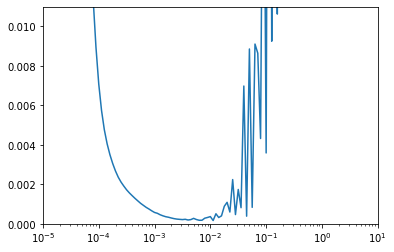

In [751]:
plt.semilogx(history_simpleRNN_msft.history["lr"], history_simpleRNN_msft.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [752]:
model_simpleRNN_msft = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

model_simpleRNN_msft.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'mean_squared_error')

history_simpleRNN_msft = model_simpleRNN_msft.fit(X_train_msft,y_train_msft ,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_msft, y_val_msft),verbose = 1)

Epoch 1/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0402 - val_loss: 0.0148
Epoch 2/100
86/86 [==============================] - 0s 570us/step - loss: 0.0110 - val_loss: 0.0091
Epoch 3/100
86/86 [==============================] - 0s 570us/step - loss: 0.0081 - val_loss: 0.0068
Epoch 4/100
86/86 [==============================] - 0s 582us/step - loss: 0.0059 - val_loss: 0.0053
Epoch 5/100
86/86 [==============================] - 0s 570us/step - loss: 0.0045 - val_loss: 0.0044
Epoch 6/100
86/86 [==============================] - 0s 559us/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/100
86/86 [==============================] - 0s 559us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/100
86/86 [==============================] - 0s 570us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 9/100
86/86 [==============================] - 0s 547us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 10/100
86/86 [==============================] - 0s 547us/step - loss: 0.0020 - val_loss

86/86 [==============================] - 0s 582us/step - loss: 2.0466e-04 - val_loss: 2.4777e-04
Epoch 78/100
86/86 [==============================] - 0s 628us/step - loss: 1.8284e-04 - val_loss: 2.4555e-04
Epoch 79/100
86/86 [==============================] - 0s 617us/step - loss: 1.8286e-04 - val_loss: 2.9410e-04
Epoch 80/100
86/86 [==============================] - 0s 594us/step - loss: 1.8720e-04 - val_loss: 2.8861e-04
Epoch 81/100
86/86 [==============================] - 0s 594us/step - loss: 1.7642e-04 - val_loss: 2.7615e-04
Epoch 82/100
86/86 [==============================] - 0s 605us/step - loss: 1.7687e-04 - val_loss: 2.3535e-04
Epoch 83/100
86/86 [==============================] - 0s 652us/step - loss: 1.8893e-04 - val_loss: 3.2742e-04
Epoch 84/100
86/86 [==============================] - 0s 640us/step - loss: 1.7274e-04 - val_loss: 2.3852e-04
Epoch 85/100
86/86 [==============================] - 0s 675us/step - loss: 1.7667e-04 - val_loss: 2.3059e-04
Epoch 86/100
86/86 [===

In [753]:
model_simpleRNN_msft.summary()

Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_37 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 121       
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

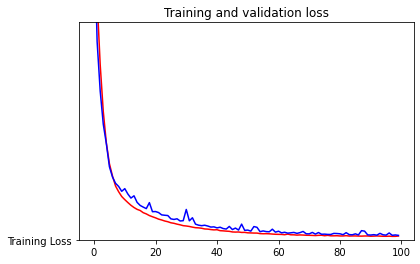

In [754]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_simpleRNN_msft=history_simpleRNN_msft.history['loss']
val_loss_simpleRNN_msft=history_simpleRNN_msft.history['val_loss']

epochs=range(len(loss_simpleRNN_msft)) 

plt.plot(epochs, loss_simpleRNN_msft, 'r', "Training Loss")
plt.plot(epochs, val_loss_simpleRNN_msft, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [755]:
X_test_msft,y_test_msft=making_test(test_sc,20)

In [756]:
y_pred_simpleRNN_msft=making_y_pred(model_simpleRNN_msft,X_test_msft)

In [757]:
mse_simpleRNN_msft,rmse_simpleRNN_msft,r_simpleRNN_msft=Eval(model_simpleRNN_msft,X_test_msft,y_test_msft,y_pred_simpleRNN_msft)

MSE: 0.001281232018162584  RMSE: 0.03579430147610907 R^2 score: 0.9862206382945695


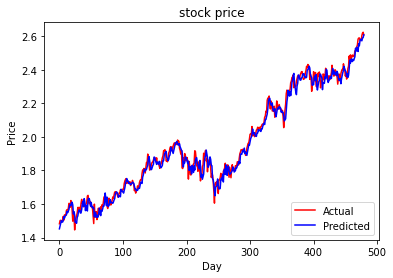

In [758]:
testset_plot(y_test_msft,y_pred_simpleRNN_msft)

#### NVDA

In [759]:
df_nvda=pd.read_csv("NVDA_indicators.csv")
df_nvda_picked = df_nvda[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']] 
windows_size=20
  
train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_nvda_picked,1500,4500,5000,5495)
X_train_nvda,y_train_nvda,X_val_nvda,y_val_nvda=making_train_val(train_sc,val_sc,windows_size)

In [760]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

model_simpleRNN_nvda = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_simpleRNN_nvda.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_simpleRNN_nvda = model_simpleRNN_nvda.fit(X_train_nvda,y_train_nvda, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 0s 628us/step - loss: 0.0281 - mae: 0.1898
Epoch 2/100
94/94 [==============================] - 0s 649us/step - loss: 0.0262 - mae: 0.1791
Epoch 3/100
94/94 [==============================] - 0s 681us/step - loss: 0.0245 - mae: 0.1697
Epoch 4/100
94/94 [==============================] - 0s 628us/step - loss: 0.0230 - mae: 0.1611
Epoch 5/100
94/94 [==============================] - 0s 628us/step - loss: 0.0216 - mae: 0.1536
Epoch 6/100
94/94 [==============================] - 0s 724us/step - loss: 0.0204 - mae: 0.1466
Epoch 7/100
94/94 [==============================] - 0s 639us/step - loss: 0.0192 - mae: 0.1404
Epoch 8/100
94/94 [==============================] - 0s 628us/step - loss: 0.0181 - mae: 0.1351
Epoch 9/100
94/94 [==============================] - 0s 735us/step - loss: 0.0170 - mae: 0.1298
Epoch 10/100
94/94 [==============================] - 0s 649us/step - loss: 0.0159 - mae: 0.1250
Epoch 11/100
94/94 [===================

94/94 [==============================] - 0s 458us/step - loss: 0.0301 - mae: 0.1872
Epoch 85/100
94/94 [==============================] - 0s 479us/step - loss: 0.0838 - mae: 0.3237
Epoch 86/100
94/94 [==============================] - 0s 471us/step - loss: 0.0472 - mae: 0.2426
Epoch 87/100
94/94 [==============================] - 0s 468us/step - loss: 0.1095 - mae: 0.3752
Epoch 88/100
94/94 [==============================] - 0s 491us/step - loss: 0.1023 - mae: 0.3648
Epoch 89/100
94/94 [==============================] - 0s 564us/step - loss: 0.0862 - mae: 0.3151
Epoch 90/100
94/94 [==============================] - 0s 467us/step - loss: 0.4952 - mae: 0.9074
Epoch 91/100
94/94 [==============================] - 0s 468us/step - loss: 0.0553 - mae: 0.2473
Epoch 92/100
94/94 [==============================] - 0s 458us/step - loss: 0.0392 - mae: 0.2168
Epoch 93/100
94/94 [==============================] - 0s 468us/step - loss: 0.1121 - mae: 0.3809
Epoch 94/100
94/94 [=======================

(1e-05, 10.0, 0.0, 0.011)

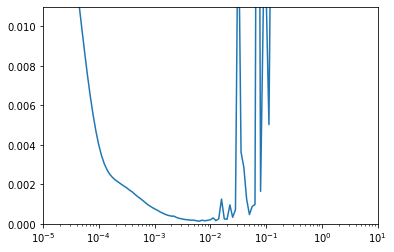

In [761]:
plt.semilogx(history_simpleRNN_nvda.history["lr"], history_simpleRNN_nvda.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [762]:
model_simpleRNN_nvda = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

model_simpleRNN_nvda.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'mean_squared_error')

history_simpleRNN_nvda = model_simpleRNN_nvda.fit(X_train_nvda,y_train_nvda ,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_nvda, y_val_nvda),verbose = 1)

Epoch 1/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0149 - val_loss: 0.2745
Epoch 2/100
47/47 [==============================] - 0s 724us/step - loss: 0.0092 - val_loss: 0.3112
Epoch 3/100
47/47 [==============================] - 0s 724us/step - loss: 0.0071 - val_loss: 0.2617
Epoch 4/100
47/47 [==============================] - 0s 703us/step - loss: 0.0058 - val_loss: 0.2366
Epoch 5/100
47/47 [==============================] - 0s 724us/step - loss: 0.0047 - val_loss: 0.2350
Epoch 6/100
47/47 [==============================] - 0s 703us/step - loss: 0.0040 - val_loss: 0.2012
Epoch 7/100
47/47 [==============================] - 0s 660us/step - loss: 0.0033 - val_loss: 0.1760
Epoch 8/100
47/47 [==============================] - 0s 745us/step - loss: 0.0028 - val_loss: 0.1642
Epoch 9/100
47/47 [==============================] - 0s 660us/step - loss: 0.0024 - val_loss: 0.1354
Epoch 10/100
47/47 [==============================] - 0s 703us/step - loss: 0.0021 - val_loss

Epoch 79/100
47/47 [==============================] - 0s 681us/step - loss: 1.0610e-04 - val_loss: 0.0116
Epoch 80/100
47/47 [==============================] - 0s 681us/step - loss: 1.0064e-04 - val_loss: 0.0072
Epoch 81/100
47/47 [==============================] - 0s 660us/step - loss: 1.0048e-04 - val_loss: 0.0077
Epoch 82/100
47/47 [==============================] - 0s 703us/step - loss: 1.1189e-04 - val_loss: 0.0073
Epoch 83/100
47/47 [==============================] - 0s 703us/step - loss: 1.0368e-04 - val_loss: 0.0076
Epoch 84/100
47/47 [==============================] - 0s 703us/step - loss: 1.0167e-04 - val_loss: 0.0074
Epoch 85/100
47/47 [==============================] - 0s 703us/step - loss: 1.0480e-04 - val_loss: 0.0078
Epoch 86/100
47/47 [==============================] - 0s 767us/step - loss: 9.9082e-05 - val_loss: 0.0072
Epoch 87/100
47/47 [==============================] - 0s 703us/step - loss: 9.9448e-05 - val_loss: 0.0070
Epoch 88/100
47/47 [==========================

In [763]:
model_simpleRNN_nvda.summary()

Model: "sequential_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 121       
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

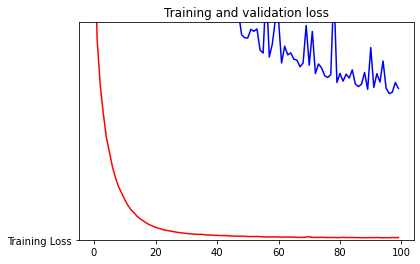

In [764]:
%matplotlib inline

loss_simpleRNN_nvda=history_simpleRNN_nvda.history['loss']
val_loss_simpleRNN_nvda=history_simpleRNN_nvda.history['val_loss']

epochs=range(len(loss_simpleRNN_nvda)) 

plt.plot(epochs, loss_simpleRNN_nvda, 'r', "Training Loss")
plt.plot(epochs, val_loss_simpleRNN_nvda, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [765]:
X_test_nvda,y_test_nvda=making_test(test_sc,20)

In [766]:
y_pred_simpleRNN_nvda=making_y_pred(model_simpleRNN_nvda,X_test_nvda)

In [767]:
mse_simpleRNN_nvda,rmse_simpleRNN_nvda,r_simpleRNN_nvda=Eval(model_simpleRNN_nvda,X_test_nvda,y_test_nvda,y_pred_simpleRNN_nvda)

MSE: 0.020713457283114786  RMSE: 0.14392170539260152 R^2 score: 0.9903552822669726


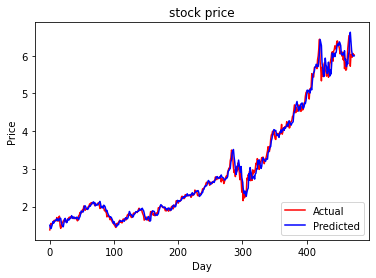

In [768]:
testset_plot(y_test_nvda,y_pred_simpleRNN_nvda)

## 3 unidirection LSTM, Dropout 0.2

### model training and evaluation with 3 related features

#### AMD

In [769]:
df_AMD=pd.read_csv("AMD_indicators.csv")
df_AMD_picked = df_AMD[['Close','High','Volume']] # Picking the features with high correlation
windows_size=20
 
train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_3features_amd,y_train_3features_amd,X_val_3features_amd,y_val_3features_amd=making_train_val(train_sc,val_sc,windows_size)

In [770]:
model_3features3lstm_amd = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(3,input_shape = (20,3),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_3features3lstm_amd.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_3features3lstm_amd = model_3features3lstm_amd.fit(X_train_3features_amd,y_train_3features_amd, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
140/140 [==============================] - 2s 11ms/step - loss: 0.0410 - mae: 0.2121
Epoch 2/100
140/140 [==============================] - 2s 11ms/step - loss: 0.0391 - mae: 0.2036
Epoch 3/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0363 - mae: 0.1914
Epoch 4/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0329 - mae: 0.1776
Epoch 5/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0285 - mae: 0.1614
Epoch 6/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0228 - mae: 0.1430
Epoch 7/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0170 - mae: 0.1310
Epoch 8/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0128 - mae: 0.1213
Epoch 9/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0087 - mae: 0.0998
Epoch 10/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0032 - mae: 0.0585
Epoch 11/100
140/140 [=======

140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1496
Epoch 84/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1499
Epoch 85/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0189 - mae: 0.1499
Epoch 86/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0191 - mae: 0.1504
Epoch 87/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0194 - mae: 0.1510
Epoch 88/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0189 - mae: 0.1499
Epoch 89/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1497
Epoch 90/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0192 - mae: 0.1501
Epoch 91/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0196 - mae: 0.1520
Epoch 92/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0199 - mae: 0.1525
Epoch 93/100
140/140 [===========

(1e-05, 10.0, 0.0, 0.011)

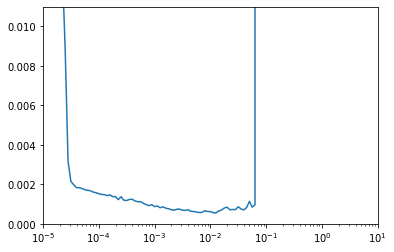

In [771]:
plt.semilogx(history_3features3lstm_amd.history["lr"], history_3features3lstm_amd.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [772]:
model_3features3lstm_amd = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(3,input_shape = (20,3),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_3features3lstm_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_3features3lstm_amd = model_3features3lstm_amd.fit(X_train_3features_amd,y_train_3features_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_3features_amd, y_val_3features_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0253 - val_loss: 0.0034
Epoch 2/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 7.9922e-04
Epoch 3/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 7.3957e-04
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 7.7634e-04
Epoch 5/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 6/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0027 - val_loss: 6.8046e-04
Epoch 7/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 8/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 7.8402e-04
Epoch 9/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 8.9044e-04
Epoch 10/100
70/70 [==============================] - 1s 12ms/step - loss: 0

70/70 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 3.5249e-04
Epoch 80/100
70/70 [==============================] - 1s 12ms/step - loss: 9.5107e-04 - val_loss: 1.6831e-04
Epoch 81/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 2.2318e-04
Epoch 82/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 2.7450e-04
Epoch 83/100
70/70 [==============================] - 1s 12ms/step - loss: 9.6317e-04 - val_loss: 3.8964e-04
Epoch 84/100
70/70 [==============================] - 1s 12ms/step - loss: 9.9437e-04 - val_loss: 4.7138e-04
Epoch 85/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 2.0942e-04
Epoch 86/100
70/70 [==============================] - 1s 12ms/step - loss: 9.4871e-04 - val_loss: 4.1227e-04
Epoch 87/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 1.9189e-04
Epoch 88/100
70/70 [==============================] 

In [773]:
model_3features3lstm_amd.summary()

Model: "sequential_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_264 (LSTM)              (None, 20, 3)             84        
_________________________________________________________________
lstm_265 (LSTM)              (None, 20, 40)            7040      
_________________________________________________________________
lstm_266 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_101 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 41        
Total params: 20,125
Trainable params: 20,125
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

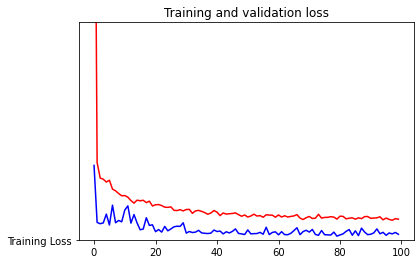

In [774]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_3features3lstm_amd=history_3features3lstm_amd.history['loss']
val_loss_3features3lstm_amd=history_3features3lstm_amd.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_3features3lstm_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_3features3lstm_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [775]:
X_test_3features3lstm_amd,y_test_3features3lstm_amd=making_test(test_sc,20)

In [776]:
y_pred_3features3lstm_amd=making_y_pred(model_3featurs3lstm_amd,X_test_3features3lstm_amd)

In [777]:
mse_3features3lstm_amd,rmse_3features3lstm_amd,r_3features3lstm_amd=Eval(model_3featurs3lstm_amd,X_test_3features3lstm_amd,y_test_3features3lstm_amd,y_pred_3features3lstm_amd)

MSE: 0.0019362756506252682  RMSE: 0.044003132281978156 R^2 score: 0.9320897327454742


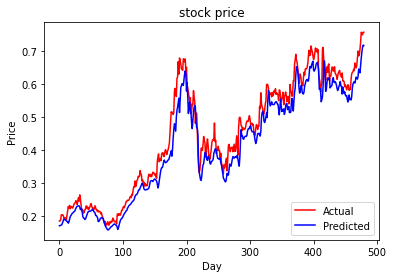

In [778]:
testset_plot(y_test_3features3lstm_amd,y_pred_3features3lstm_amd)

#### MSFT

In [779]:
df_MSFT=pd.read_csv("msft_indicators.csv")
df_MSFT_picked = df_MSFT[['Close','High','Volume']] # Picking the features with high correlation
windows_size=20

train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_MSFT_picked,2000,7500,8000,8500)
X_train_3features_msft,y_train_3features_msft,X_val_3features_msft,y_val_3features_msft=making_train_val(train_sc,val_sc,windows_size)

In [780]:
model_3featurs3lstm_msft = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(3,input_shape = (20,3),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_3featurs3lstm_msft.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_3featurs3lstm_msft = model_3featurs3lstm_msft.fit(X_train_3features_msft,y_train_3features_msft, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 3s 17ms/step - loss: 0.1081 - mae: 0.4208
Epoch 2/100
172/172 [==============================] - 3s 16ms/step - loss: 0.1030 - mae: 0.4088
Epoch 3/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0954 - mae: 0.3910
Epoch 4/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0822 - mae: 0.3606
Epoch 5/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0582 - mae: 0.3010
Epoch 6/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0261 - mae: 0.1869
Epoch 7/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0173 - mae: 0.1387
Epoch 8/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0151 - mae: 0.1291
Epoch 9/100
172/172 [==============================] - 3s 15ms/step - loss: 0.0129 - mae: 0.1202
Epoch 10/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0100 - mae: 0.1051
Epoch 11/100
172/172 [=======

172/172 [==============================] - 3s 15ms/step - loss: 1.6760 - mae: 2.0778
Epoch 83/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6624 - mae: 2.0663
Epoch 84/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6715 - mae: 2.0733
Epoch 85/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6549 - mae: 2.0635
Epoch 86/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6775 - mae: 2.0776
Epoch 87/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6213 - mae: 2.0251
Epoch 88/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6420 - mae: 2.0420
Epoch 89/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6303 - mae: 2.0366
Epoch 90/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6688 - mae: 2.0740
Epoch 91/100
172/172 [==============================] - 3s 15ms/step - loss: 1.6031 - mae: 2.0040
Epoch 92/100
172/172 [===========

(1e-05, 10.0, 0.0, 0.011)

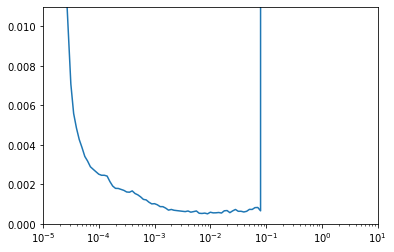

In [781]:
plt.semilogx(history_3featurs3lstm_msft.history["lr"], history_3featurs3lstm_msft.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [782]:
model_3featurs3lstm_msft = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(3,input_shape = (20,3),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_3featurs3lstm_msft.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'mean_squared_error')

history_3featurs3lstm_msft = model_3featurs3lstm_msft.fit(X_train_3features_msft,y_train_3features_msft,epochs = 100 ,batch_size = 128 ,validation_data = (X_val_3features_msft, y_val_3features_msft),verbose = 1)

Epoch 1/100
43/43 [==============================] - 1s 29ms/step - loss: 0.2118 - val_loss: 1.0926
Epoch 2/100
43/43 [==============================] - 1s 21ms/step - loss: 0.1839 - val_loss: 0.9830
Epoch 3/100
43/43 [==============================] - 1s 21ms/step - loss: 0.1420 - val_loss: 0.7961
Epoch 4/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0733 - val_loss: 0.3689
Epoch 5/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0165 - val_loss: 0.0656
Epoch 6/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0079 - val_loss: 0.0263
Epoch 7/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0064 - val_loss: 0.0252
Epoch 8/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0059 - val_loss: 0.0197
Epoch 9/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0058 - val_loss: 0.0176
Epoch 10/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0058 - val_loss: 0.0158

43/43 [==============================] - 1s 20ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 83/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 84/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 85/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 86/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 87/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 88/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0031 - val_loss: 9.9118e-04
Epoch 89/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 90/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 91/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0032 - val_loss: 9.8779

In [783]:
model_3featurs3lstm_msft.summary()

Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_270 (LSTM)              (None, 20, 3)             84        
_________________________________________________________________
lstm_271 (LSTM)              (None, 20, 40)            7040      
_________________________________________________________________
lstm_272 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_103 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 41        
Total params: 20,125
Trainable params: 20,125
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

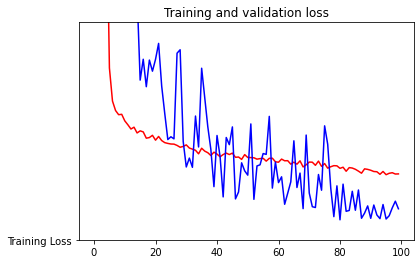

In [784]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_3features3lstm_msft=history_3featurs3lstm_msft.history['loss']
val_loss_3features3lstm_msft=history_3featurs3lstm_msft.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_3features3lstm_msft, 'r', "Training Loss")
plt.plot(epochs, val_loss_3features3lstm_msft, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [785]:
X_test_3features3lstm_msft,y_test_3features3lstm_msft=making_test(test_sc,20)

In [786]:
y_pred_3features3lstm_msft=making_y_pred(model_3featurs3lstm_msft,X_test_3features3lstm_msft)

In [787]:
mse_3features3lstm_msft,rmse_3features3lstm_msft,r_3features3lstm_msft=Eval(model_3featurs3lstm_msft,X_test_3features3lstm_msft,y_test_3features3lstm_msft,y_pred_3features3lstm_msft)

MSE: 0.899686072303368  RMSE: 0.9485178291963562 R^2 score: -8.675921016542278


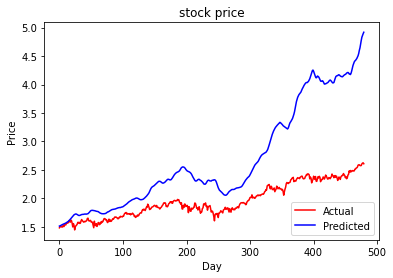

In [788]:
testset_plot(y_test_3features3lstm_msft,y_pred_3features3lstm_msft)

#### NVDA

In [792]:
df_nvda=pd.read_csv("NVDA_indicators.csv")
df_nvda_picked = df_nvda[['Close','High','Volume']] # Picking the features with high correlation
windows_size=20

train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_nvda_picked,1500,4500,5000,5495)
X_train_3features_nvda,y_train_3features_nvda,X_val_3features_nvda,y_val_3features_nvda=making_train_val(train_sc,val_sc,windows_size)

In [793]:
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,10 DAYS EMA,20 DAYS EMA,RSI,MACD
0,1999-01-22,1.750000,1.953125,1.552083,1.640625,1.508857,67867200.0,0.401042,-0.109375,0.000000,0.000000,0.000000,0.000000,1.640625,1.640625,NaN,0.000000
1,1999-01-25,1.770833,1.833333,1.640625,1.812500,1.666928,12762000.0,0.192708,0.041667,0.000000,0.000000,0.000000,0.000000,1.671875,1.656994,NaN,0.013711
2,1999-01-26,1.833333,1.869792,1.645833,1.671875,1.537597,8580000.0,0.223958,-0.161458,0.000000,0.000000,0.000000,0.000000,1.671875,1.658411,NaN,0.013079
3,1999-01-27,1.677083,1.718750,1.583333,1.666667,1.532807,6109200.0,0.135417,-0.010417,0.000000,0.000000,0.000000,0.000000,1.670928,1.659198,NaN,0.012019
4,1999-01-28,1.666667,1.677083,1.651042,1.661458,1.528017,5688000.0,0.026042,-0.005208,0.000000,0.000000,0.000000,0.000000,1.669206,1.659413,NaN,0.010636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,2020-11-13,545.090027,546.750000,522.369995,531.880005,531.880005,8657800.0,24.380005,-13.210022,547.381426,531.757145,536.220476,33.304724,536.543296,536.106889,49.028108,1.627440
5492,2020-11-16,526.900024,545.979980,526.239990,540.609985,540.609985,10344400.0,19.739990,13.709961,544.539995,532.202144,534.938572,31.017782,537.282694,536.535755,51.183731,1.831262
5493,2020-11-17,542.099976,543.849976,532.150024,536.890015,536.890015,7800700.0,11.699951,-5.209961,540.855704,532.540715,534.374285,25.591824,537.211298,536.569494,50.905753,1.673332
5494,2020-11-18,538.609985,544.229980,527.400024,537.150024,537.150024,12773100.0,16.829956,-1.459961,534.342852,534.812860,534.230477,13.129894,537.200157,536.624783,56.779918,1.551271


In [794]:
model_3featurs3lstm_nvda = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(3,input_shape = (20,3),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_3featurs3lstm_nvda.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_3featurs3lstm_nvda = model_3featurs3lstm_nvda.fit(X_train_3features_nvda,y_train_3features_nvda, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 2s 18ms/step - loss: 0.0196 - mae: 0.1470
Epoch 2/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0186 - mae: 0.1408
Epoch 3/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0174 - mae: 0.1335
Epoch 4/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0159 - mae: 0.1231
Epoch 5/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0138 - mae: 0.1099
Epoch 6/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0115 - mae: 0.0940
Epoch 7/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0086 - mae: 0.0732
Epoch 8/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0062 - mae: 0.0633
Epoch 9/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0047 - mae: 0.0610
Epoch 10/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0036 - mae: 0.0566
Epoch 11/100
94/94 [=============================

94/94 [==============================] - 1s 16ms/step - loss: 0.0099 - mae: 0.0919
Epoch 85/100
94/94 [==============================] - 1s 16ms/step - loss: 0.0097 - mae: 0.0900
Epoch 86/100
94/94 [==============================] - 1s 16ms/step - loss: 0.0100 - mae: 0.0929
Epoch 87/100
94/94 [==============================] - 1s 15ms/step - loss: 0.0100 - mae: 0.0927
Epoch 88/100
94/94 [==============================] - 1s 16ms/step - loss: 0.0098 - mae: 0.0915
Epoch 89/100
94/94 [==============================] - 1s 16ms/step - loss: 0.0104 - mae: 0.0959
Epoch 90/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0096 - mae: 0.0887
Epoch 91/100
94/94 [==============================] - 1s 16ms/step - loss: 0.0102 - mae: 0.0936
Epoch 92/100
94/94 [==============================] - 1s 16ms/step - loss: 0.0123 - mae: 0.1101
Epoch 93/100
94/94 [==============================] - 1s 16ms/step - loss: 0.0102 - mae: 0.0942
Epoch 94/100
94/94 [==============================] -

(1e-05, 10.0, 0.0, 0.011)

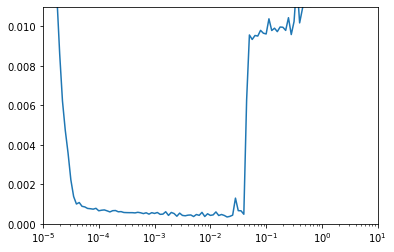

In [795]:
plt.semilogx(history_3featurs3lstm_nvda.history["lr"], history_3featurs3lstm_nvda.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [796]:
model_3featurs3lstm_nvda = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(3,input_shape = (20,3),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_3featurs3lstm_nvda.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'mean_squared_error')

history_3featurs3lstm_nvda = model_3featurs3lstm_nvda.fit(X_train_3features_nvda,y_train_3features_nvda,epochs = 100 ,batch_size = 128 ,validation_data = (X_val_3features_nvda, y_val_3features_nvda),verbose = 1)

Epoch 1/100
24/24 [==============================] - 1s 36ms/step - loss: 0.0404 - val_loss: 4.8711
Epoch 2/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0371 - val_loss: 4.8152
Epoch 3/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0332 - val_loss: 4.7435
Epoch 4/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0289 - val_loss: 4.6462
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0241 - val_loss: 4.5159
Epoch 6/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0202 - val_loss: 4.3567
Epoch 7/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0185 - val_loss: 4.2614
Epoch 8/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0182 - val_loss: 4.2547
Epoch 9/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0181 - val_loss: 4.2414
Epoch 10/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0176 - val_loss: 4.2015

24/24 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0793
Epoch 83/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 0.0822
Epoch 84/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 0.0822
Epoch 85/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.1024
Epoch 86/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0785
Epoch 87/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 0.0783
Epoch 88/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0784
Epoch 89/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0782
Epoch 90/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 0.0807
Epoch 91/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0783
Epo

In [797]:
model_3featurs3lstm_nvda.summary()

Model: "sequential_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_276 (LSTM)              (None, 20, 3)             84        
_________________________________________________________________
lstm_277 (LSTM)              (None, 20, 40)            7040      
_________________________________________________________________
lstm_278 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_105 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 41        
Total params: 20,125
Trainable params: 20,125
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

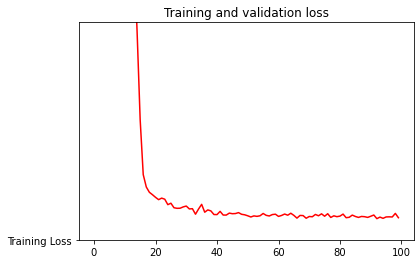

In [798]:
%matplotlib inline

loss_3features3lstm_nvda=history_3featurs3lstm_nvda.history['loss']
val_loss_3features3lstm_nvda=history_3featurs3lstm_nvda.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_3features3lstm_nvda, 'r', "Training Loss")
plt.plot(epochs, val_loss_3features3lstm_nvda, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [799]:
X_test_3features3lstm_nvda,y_test_3features3lstm_nvda=making_test(test_sc,20)
y_pred_3features3lstm_nvda=making_y_pred(model_3featurs3lstm_nvda,X_test_3features3lstm_nvda)
mse_3features3lstm_nvda,rmse_3features3lstm_nvda,r_3features3lstm_nvda=Eval(model_3featurs3lstm_nvda,X_test_3features3lstm_nvda,y_test_3features3lstm_nvda,y_pred_3features3lstm_nvda)

MSE: 1.3884554926863248  RMSE: 1.1783274131947898 R^2 score: 0.3534994603364734


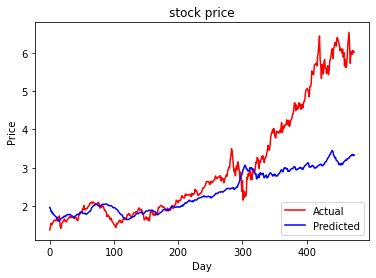

In [800]:
testset_plot(y_test_3features3lstm_nvda,y_pred_3features3lstm_nvda)

### model training and evaluation with 6 indicators

#### AMD

In [801]:
df_AMD=pd.read_csv("AMD_indicators.csv")
df_AMD_picked = df_AMD[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20
  
train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)

In [802]:
model_6features3lstm_amd = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_6features3lstm_amd.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_6features3lstm_amd = model_6features3lstm_amd.fit(X_train_amd,y_train_amd, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0433 - mae: 0.2218
Epoch 2/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0398 - mae: 0.2057
Epoch 3/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0351 - mae: 0.1856
Epoch 4/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0289 - mae: 0.1623
Epoch 5/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0230 - mae: 0.1448
Epoch 6/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0197 - mae: 0.1431
Epoch 7/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0189 - mae: 0.1453
Epoch 8/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0184 - mae: 0.1441
Epoch 9/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0181 - mae: 0.1438
Epoch 10/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0177 - mae: 0.1424
Epoch 11/100
140/140 [=======

140/140 [==============================] - 1s 10ms/step - loss: 0.0187 - mae: 0.1495
Epoch 83/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1497
Epoch 84/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1496
Epoch 85/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1499
Epoch 86/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1493
Epoch 87/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1495
Epoch 88/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0188 - mae: 0.1497
Epoch 89/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0191 - mae: 0.1504
Epoch 90/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0189 - mae: 0.1499
Epoch 91/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0189 - mae: 0.1498
Epoch 92/100
140/140 [===========

(1e-05, 10.0, 0.0, 0.011)

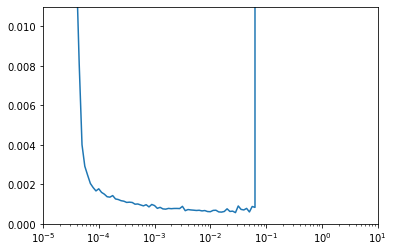

In [803]:
plt.semilogx(history_6features3lstm_amd.history["lr"], history_6features3lstm_amd.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [804]:
model_6features3lstm_amd = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_6features3lstm_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_6features3lstm_amd = model_6features3lstm_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 18ms/step - loss: 0.0217 - val_loss: 0.0032
Epoch 2/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 3/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 8.0562e-04
Epoch 5/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 6/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 9.6583e-04
Epoch 7/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 7.2171e-04
Epoch 8/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 9/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 8.1908e-04
Epoch 10/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0021 - 

70/70 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 2.3053e-04
Epoch 80/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 2.1651e-04
Epoch 81/100
70/70 [==============================] - 1s 12ms/step - loss: 9.1336e-04 - val_loss: 4.7149e-04
Epoch 82/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 2.7109e-04
Epoch 83/100
70/70 [==============================] - 1s 12ms/step - loss: 9.5709e-04 - val_loss: 2.0900e-04
Epoch 84/100
70/70 [==============================] - 1s 12ms/step - loss: 9.9199e-04 - val_loss: 1.9526e-04
Epoch 85/100
70/70 [==============================] - 1s 12ms/step - loss: 8.7762e-04 - val_loss: 2.3607e-04
Epoch 86/100
70/70 [==============================] - 1s 12ms/step - loss: 8.8669e-04 - val_loss: 2.4967e-04
Epoch 87/100
70/70 [==============================] - 1s 12ms/step - loss: 9.8801e-04 - val_loss: 1.8272e-04
Epoch 88/100
70/70 [========================

In [805]:
model_6features3lstm_amd.summary()

Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_282 (LSTM)              (None, 20, 6)             312       
_________________________________________________________________
lstm_283 (LSTM)              (None, 20, 40)            7520      
_________________________________________________________________
lstm_284 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_107 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 41        
Total params: 20,833
Trainable params: 20,833
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

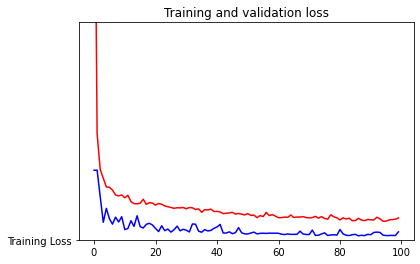

In [806]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_6features_amd=history_6features3lstm_amd.history['loss']
val_loss_6features_amd=history_6features3lstm_amd.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_6features_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_6features_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [807]:
X_test_amd,y_test_amd=making_test(test_sc,20)
y_pred_6features3lstm_amd=making_y_pred(model_6features3lstm_amd,X_test_amd)
mse_6features3lstm_amd,rmse_6features3lstm_amd,r_6features3lstm_amd=Eval(model_6features3lstm_amd,X_test_amd,y_test_amd,y_pred_6features3lstm_amd)

MSE: 0.0022513534137472133  RMSE: 0.047448428991350315 R^2 score: 0.9210391289264055


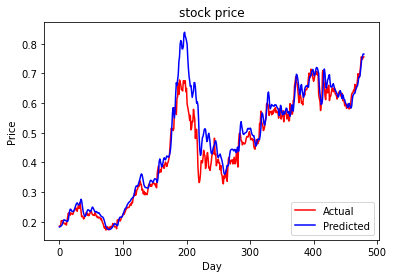

In [808]:
testset_plot(y_test_amd,y_pred_6features3lstm_amd)

#### MSFT

In [809]:
df_MSFT=pd.read_csv("msft_indicators.csv")
df_MSFT_picked = df_MSFT[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20

train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_MSFT_picked,2000,7500,8000,8500)
X_train_msft,y_train_msft,X_val_msft,y_val_msft=making_train_val(train_sc,val_sc,windows_size)

In [810]:
model_6features3lstm_msft = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_6features3lstm_msft.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_6features3lstm_msft = model_6features3lstm_msft.fit(X_train_msft,y_train_msft, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 3s 17ms/step - loss: 0.1100 - mae: 0.4245
Epoch 2/100
172/172 [==============================] - 3s 16ms/step - loss: 0.1012 - mae: 0.4049
Epoch 3/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0907 - mae: 0.3816
Epoch 4/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0719 - mae: 0.3384
Epoch 5/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0404 - mae: 0.2512
Epoch 6/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0143 - mae: 0.1362
Epoch 7/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0111 - mae: 0.1148
Epoch 8/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0093 - mae: 0.1053
Epoch 9/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0083 - mae: 0.1005
Epoch 10/100
172/172 [==============================] - 3s 16ms/step - loss: 0.0075 - mae: 0.0946
Epoch 11/100
172/172 [=======

172/172 [==============================] - 3s 16ms/step - loss: 285637471109120.0000 - mae: 285637471109120.0000
Epoch 84/100
172/172 [==============================] - 3s 16ms/step - loss: 7391.5620 - mae: 7392.0620
Epoch 85/100
172/172 [==============================] - 3s 16ms/step - loss: 3401.7573 - mae: 3402.2561
Epoch 86/100
172/172 [==============================] - 3s 16ms/step - loss: 2960.6489 - mae: 2961.1479
Epoch 87/100
172/172 [==============================] - 3s 16ms/step - loss: 2747.3252 - mae: 2747.8247
Epoch 88/100
172/172 [==============================] - 3s 16ms/step - loss: 2332.1565 - mae: 2332.6555
Epoch 89/100
172/172 [==============================] - 3s 16ms/step - loss: 2174.8074 - mae: 2175.3074
Epoch 90/100
172/172 [==============================] - 3s 16ms/step - loss: 1948.7534 - mae: 1949.2527
Epoch 91/100
172/172 [==============================] - 3s 16ms/step - loss: 1832.2843 - mae: 1832.7843
Epoch 92/100
172/172 [==============================] -

(1e-05, 10.0, 0.0, 0.011)

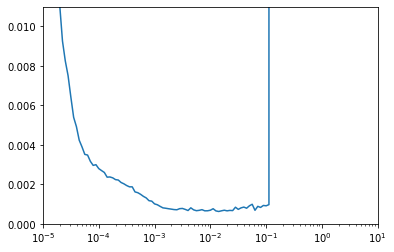

In [811]:
plt.semilogx(history_6features3lstm_msft.history["lr"], history_6features3lstm_msft.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [812]:
model_6features3lstm_msft = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_6features3lstm_msft.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_6features3lstm_msft = model_6features3lstm_msft.fit(X_train_msft,y_train_msft,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_msft, y_val_msft),verbose = 1)

Epoch 1/100
86/86 [==============================] - 2s 26ms/step - loss: 0.0727 - val_loss: 0.4315
Epoch 2/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0179 - val_loss: 0.0570
Epoch 3/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0062 - val_loss: 0.0111
Epoch 4/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0043 - val_loss: 0.0069
Epoch 5/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0039 - val_loss: 0.0070
Epoch 6/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 7/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 8/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 9/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0108
Epoch 10/100
86/86 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0075

86/86 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 83/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 84/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 0.0094
Epoch 85/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0011 - val_loss: 0.0097
Epoch 86/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 87/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 0.0095
Epoch 88/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 89/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0011 - val_loss: 0.0093
Epoch 90/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 91/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0011 - val_loss: 0.0031
Epo

In [813]:
model_6features3lstm_msft.summary()

Model: "sequential_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_288 (LSTM)              (None, 20, 6)             312       
_________________________________________________________________
lstm_289 (LSTM)              (None, 20, 40)            7520      
_________________________________________________________________
lstm_290 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_109 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 1)                 41        
Total params: 20,833
Trainable params: 20,833
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

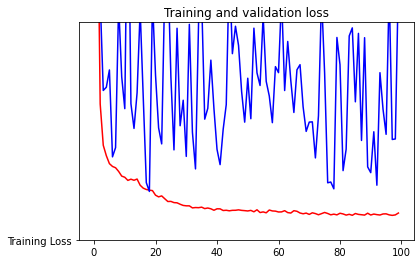

In [814]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_6features3lstm_msft=history_6features3lstm_msft.history['loss']
val_loss_6features3lstm_msft=history_6features3lstm_msft.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_6features3lstm_msft, 'r', "Training Loss")
plt.plot(epochs, val_loss_6features3lstm_msft, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [815]:
X_test_msft,y_test_msft=making_test(test_sc,20)
y_pred_6features3lstm_msft=making_y_pred(model_6features3lstm_msft,X_test_msft)
mse_6features3lstm_msft,rmse_6features3lstm_msft,r_6features3lstm_msft=Eval(model_6features3lstm_msft,X_test_msft,y_test_msft,y_pred_6features3lstm_msft)

MSE: 0.5406658109293  RMSE: 0.7352998102334176 R^2 score: -4.814738989460183


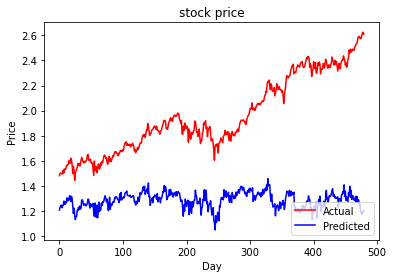

In [816]:
testset_plot(y_test_msft,y_pred_6features3lstm_msft)

#### NVDA

In [821]:
df_nvda=pd.read_csv("NVDA_indicators.csv")
df_nvda_picked = df_nvda[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20

train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_nvda_picked,1500,4500,5000,5495)
X_train_nvda,y_train_nvda,X_val_nvda,y_val_nvda=making_train_val(train_sc,val_sc,windows_size)

In [822]:
model_6features3lstm_nvda = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_6features3lstm_nvda.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_6features3lstm_nvda = model_6features3lstm_nvda.fit(X_train_nvda,y_train_nvda, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 2s 18ms/step - loss: 0.0194 - mae: 0.1433
Epoch 2/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0177 - mae: 0.1314
Epoch 3/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0160 - mae: 0.1193
Epoch 4/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0138 - mae: 0.1039
Epoch 5/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0118 - mae: 0.0898
Epoch 6/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0100 - mae: 0.0816
Epoch 7/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0092 - mae: 0.0810
Epoch 8/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0089 - mae: 0.0838: 0s - loss: 0.0088 - 
Epoch 9/100
94/94 [==============================] - 1s 16ms/step - loss: 0.0086 - mae: 0.0833
Epoch 10/100
94/94 [==============================] - 2s 16ms/step - loss: 0.0084 - mae: 0.0825
Epoch 11/100
94/94 [=======

94/94 [==============================] - 1s 16ms/step - loss: 0.0096 - mae: 0.0894
Epoch 85/100
94/94 [==============================] - 1s 16ms/step - loss: 8366163230720.0000 - mae: 8366163230720.0000
Epoch 86/100
94/94 [==============================] - 2s 16ms/step - loss: 2301773905657856.0000 - mae: 2301773905657856.0000
Epoch 87/100
94/94 [==============================] - 1s 16ms/step - loss: 5665.0693 - mae: 5665.5693
Epoch 88/100
94/94 [==============================] - 1s 16ms/step - loss: 5540.5132 - mae: 5541.0132
Epoch 89/100
94/94 [==============================] - 1s 16ms/step - loss: 5400.8486 - mae: 5401.3486
Epoch 90/100
94/94 [==============================] - 1s 16ms/step - loss: 5164.8491 - mae: 5165.3491
Epoch 91/100
94/94 [==============================] - 1s 16ms/step - loss: 4969.0059 - mae: 4969.5059
Epoch 92/100
94/94 [==============================] - 1s 16ms/step - loss: 4693.3052 - mae: 4693.8052
Epoch 93/100
94/94 [==============================] - 1s 16

(1e-05, 10.0, 0.0, 0.011)

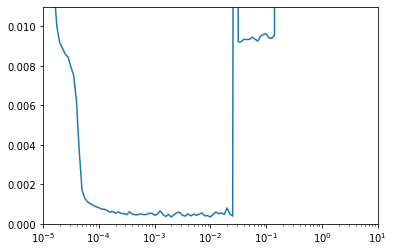

In [823]:
plt.semilogx(history_6features3lstm_nvda.history["lr"], history_6features3lstm_nvda.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [824]:
model_6features3lstm_nvda = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_6features3lstm_nvda.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_6features3lstm_nvda = model_6features3lstm_nvda.fit(X_train_nvda,y_train_nvda,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_nvda, y_val_nvda),verbose = 1)

Epoch 1/100
47/47 [==============================] - 1s 27ms/step - loss: 0.0160 - val_loss: 2786.6809
Epoch 2/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0056 - val_loss: 693.6744
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 16.5076
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 14.7316
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.1980
Epoch 6/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 1.7843
Epoch 7/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 3.6632
Epoch 8/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 4.8823
Epoch 9/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 4.9802
Epoch 10/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss:

47/47 [==============================] - 1s 19ms/step - loss: 6.8954e-04 - val_loss: 2.2156
Epoch 80/100
47/47 [==============================] - 1s 19ms/step - loss: 5.4266e-04 - val_loss: 2.0721
Epoch 81/100
47/47 [==============================] - 1s 19ms/step - loss: 6.3318e-04 - val_loss: 2.3286
Epoch 82/100
47/47 [==============================] - 1s 19ms/step - loss: 5.4524e-04 - val_loss: 2.2145
Epoch 83/100
47/47 [==============================] - 1s 19ms/step - loss: 6.0877e-04 - val_loss: 2.0868
Epoch 84/100
47/47 [==============================] - 1s 19ms/step - loss: 6.5141e-04 - val_loss: 1.6764
Epoch 85/100
47/47 [==============================] - 1s 19ms/step - loss: 5.6545e-04 - val_loss: 2.0974
Epoch 86/100
47/47 [==============================] - 1s 19ms/step - loss: 5.6353e-04 - val_loss: 1.4049
Epoch 87/100
47/47 [==============================] - 1s 19ms/step - loss: 5.6902e-04 - val_loss: 1.6857
Epoch 88/100
47/47 [==============================] - 1s 19ms/step -

In [825]:
model_6features3lstm_nvda.summary()

Model: "sequential_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_297 (LSTM)              (None, 20, 6)             312       
_________________________________________________________________
lstm_298 (LSTM)              (None, 20, 40)            7520      
_________________________________________________________________
lstm_299 (LSTM)              (None, 40)                12960     
_________________________________________________________________
dropout_112 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 41        
Total params: 20,833
Trainable params: 20,833
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

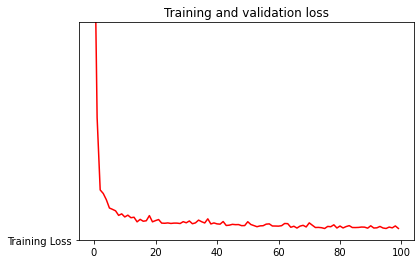

In [826]:
%matplotlib inline

loss_6features3lstm_nvda=history_6features3lstm_nvda.history['loss']
val_loss_6features3lstm_nvda=history_6features3lstm_nvda.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_6features3lstm_nvda, 'r', "Training Loss")
plt.plot(epochs, val_loss_6features3lstm_nvda, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [827]:
X_test_nvda,y_test_nvda=making_test(test_sc,20)
y_pred_6features3lstm_nvda=making_y_pred(model_6features3lstm_nvda,X_test_nvda)
mse_6features3lstm_nvda,rmse_6features3lstm_nvda,r_6features3lstm_nvda=Eval(model_6features3lstm_nvda,X_test_nvda,y_test_nvda,y_pred_6features3lstm_nvda)

MSE: 6.639559032794324  RMSE: 2.5767341796922563 R^2 score: -2.0915492217359217


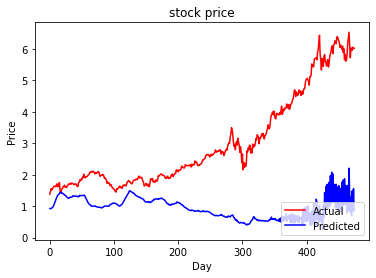

In [828]:
testset_plot(y_test_nvda,y_pred_6features3lstm_nvda)

## 3 Bidirectional LSTM, Dropout 0.2 

### Basic 3 bidirectional LSTM

#### AMD

In [829]:
df_AMD=pd.read_csv("AMD_indicators.csv")
df_AMD_picked = df_AMD[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20  

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_6features_amd,y_train_6features_amd,X_val_6features_amd,y_val_6features_amd=making_train_val(train_sc,val_sc,windows_size)

In [830]:
model_6featuresbi3lstm_amd = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_6featuresbi3lstm_amd.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_6featuresbi3lstm_amd = model_6featuresbi3lstm_amd.fit(X_train_6features_amd,y_train_6features_amd, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0444 - mae: 0.2187
Epoch 2/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0276 - mae: 0.1595
Epoch 3/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0175 - mae: 0.1290
Epoch 4/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0120 - mae: 0.1147
Epoch 5/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0090 - mae: 0.1013
Epoch 6/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0059 - mae: 0.0810
Epoch 7/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0035 - mae: 0.0600
Epoch 8/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0023 - mae: 0.0484
Epoch 9/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0021 - mae: 0.0463
Epoch 10/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0020 - mae: 0.0441
Epoch 11/100
140/140 [=======

140/140 [==============================] - 2s 13ms/step - loss: 6.1453e-04 - mae: 0.0247
Epoch 83/100
140/140 [==============================] - 2s 13ms/step - loss: 8.9451e-04 - mae: 0.0302
Epoch 84/100
140/140 [==============================] - 2s 13ms/step - loss: 5.7786e-04 - mae: 0.0241
Epoch 85/100
140/140 [==============================] - 2s 13ms/step - loss: 4.8785e-04 - mae: 0.0226
Epoch 86/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0916 - mae: 0.2401
Epoch 87/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0225 - mae: 0.1620
Epoch 88/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0238 - mae: 0.1666
Epoch 89/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0219 - mae: 0.1594
Epoch 90/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0249 - mae: 0.1733
Epoch 91/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0252 - mae: 0.1730
Epoch 92/100
140/

(1e-05, 10.0, 0.0, 0.011)

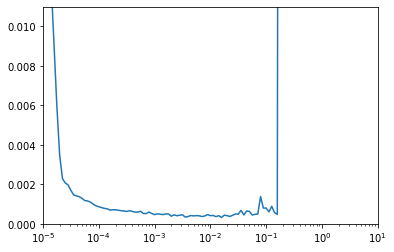

In [831]:
plt.semilogx(history_6featuresbi3lstm_amd.history["lr"], history_6featuresbi3lstm_amd.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [832]:
model_6featuresbi3lstm_amd = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_6featuresbi3lstm_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_6featuresbi3lstm_amd = model_6featuresbi3lstm_amd.fit(X_train_6features_amd,y_train_6features_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_6features_amd, y_val_6features_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 3s 43ms/step - loss: 0.0120 - val_loss: 0.0026
Epoch 2/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 8.1090e-04
Epoch 3/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 6.5403e-04
Epoch 4/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 7.4776e-04
Epoch 5/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 5.9848e-04
Epoch 6/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 6.4884e-04
Epoch 7/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 4.3523e-04
Epoch 8/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 3.9485e-04
Epoch 9/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 3.9798e-04
Epoch 10/100
70/70 [==============================] - 1s 16ms/step -

Epoch 77/100
70/70 [==============================] - 1s 16ms/step - loss: 5.1542e-04 - val_loss: 1.8300e-04
Epoch 78/100
70/70 [==============================] - 1s 16ms/step - loss: 5.3482e-04 - val_loss: 1.2474e-04
Epoch 79/100
70/70 [==============================] - 1s 16ms/step - loss: 5.1899e-04 - val_loss: 3.4954e-04
Epoch 80/100
70/70 [==============================] - 1s 16ms/step - loss: 5.3096e-04 - val_loss: 1.4004e-04
Epoch 81/100
70/70 [==============================] - 1s 16ms/step - loss: 5.0038e-04 - val_loss: 1.1195e-04
Epoch 82/100
70/70 [==============================] - 1s 16ms/step - loss: 5.0261e-04 - val_loss: 1.2612e-04
Epoch 83/100
70/70 [==============================] - 1s 16ms/step - loss: 5.6098e-04 - val_loss: 1.3440e-04
Epoch 84/100
70/70 [==============================] - 1s 16ms/step - loss: 4.9750e-04 - val_loss: 1.8301e-04
Epoch 85/100
70/70 [==============================] - 1s 16ms/step - loss: 5.3050e-04 - val_loss: 1.5613e-04
Epoch 86/100
70/70 

In [833]:
model_6featuresbi3lstm_amd.summary()

Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_67 (Bidirectio (None, 20, 12)            624       
_________________________________________________________________
bidirectional_68 (Bidirectio (None, 20, 80)            16960     
_________________________________________________________________
lstm_305 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_114 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 41        
Total params: 36,985
Trainable params: 36,985
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

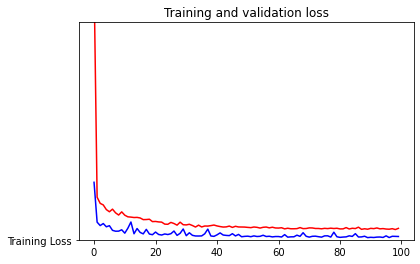

In [834]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_6featuresbi_amd=history_6featuresbi3lstm_amd.history['loss']
val_loss_6featuresbi_amd=history_6featuresbi3lstm_amd.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_6featuresbi_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_6featuresbi_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [883]:
X_test_6features_amd,y_test_6features_amd=making_test(test_sc,20)
y_pred_6featuresbi3lstm_amd=making_y_pred(model_6featuresbi3lstm_amd,X_test_6features_amd)
mse_6featuresbi3lstm_amd,rmse_6featuresbi3lstm_amd,r_6featuresbi3lstm_amd=Eval(model_6featuresbi3lstm_amd,X_test_6features_amd,y_test_6features_amd,y_pred_6featuresbi3lstm_amd)

TypeError: Eval() takes 3 positional arguments but 4 were given

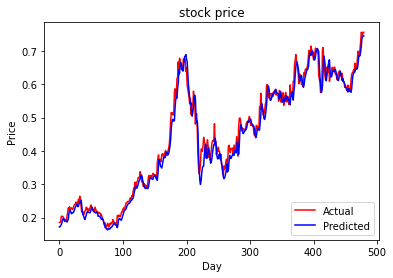

In [836]:
testset_plot(y_test_6features_amd,y_pred_6featuresbi3lstm_amd)

#### MSFT

In [890]:
df_msft=pd.read_csv("msft_indicators.csv")
df_msft_picked = df_msft[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20

train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_MSFT_picked,2000,7500,8000,8500)
X_train_6features_msft,y_train_6features_msft,X_val_6features_msft,y_val_6features_msft=making_train_val(train_sc,val_sc,windows_size)

In [838]:
model_6featuresbi3lstm_msft =tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_6featuresbi3lstm_msft.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_6featuresbi3lstm_msft = model_6featuresbi3lstm_msft.fit(X_train_6features_msft,y_train_6features_msft, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 4s 21ms/step - loss: 0.0930 - mae: 0.3890
Epoch 2/100
172/172 [==============================] - 4s 21ms/step - loss: 0.0581 - mae: 0.3013
Epoch 3/100
172/172 [==============================] - 4s 21ms/step - loss: 0.0279 - mae: 0.2009
Epoch 4/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0140 - mae: 0.1318
Epoch 5/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0088 - mae: 0.1053
Epoch 6/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0067 - mae: 0.0925
Epoch 7/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0057 - mae: 0.0840
Epoch 8/100
172/172 [==============================] - 4s 20ms/step - loss: 0.0054 - mae: 0.0809
Epoch 9/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0050 - mae: 0.0784
Epoch 10/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0044 - mae: 0.0734: 1s -
Epoch 11/100
172/172 [=

172/172 [==============================] - 3s 19ms/step - loss: 4.9751e-04 - mae: 0.0234
Epoch 83/100
172/172 [==============================] - 3s 19ms/step - loss: 6.8387e-04 - mae: 0.0280
Epoch 84/100
172/172 [==============================] - 3s 19ms/step - loss: 4.9194e-04 - mae: 0.0228
Epoch 85/100
172/172 [==============================] - 3s 19ms/step - loss: 0.0010 - mae: 0.0347
Epoch 86/100
172/172 [==============================] - 3s 19ms/step - loss: 0.2586 - mae: 0.4846
Epoch 87/100
172/172 [==============================] - 3s 19ms/step - loss: 0.0377 - mae: 0.2171
Epoch 88/100
172/172 [==============================] - 3s 19ms/step - loss: 0.0339 - mae: 0.2050
Epoch 89/100
172/172 [==============================] - 3s 19ms/step - loss: 0.0462 - mae: 0.2447
Epoch 90/100
172/172 [==============================] - 3s 19ms/step - loss: 0.0319 - mae: 0.2011
Epoch 91/100
172/172 [==============================] - 3s 19ms/step - loss: 0.0476 - mae: 0.2439
Epoch 92/100
172/172 

(1e-05, 10.0, 0.0, 0.011)

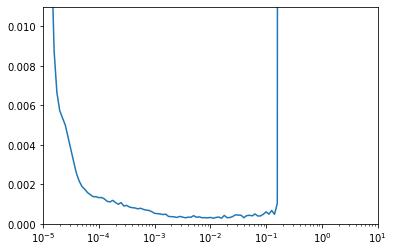

In [839]:
plt.semilogx(history_6featuresbi3lstm_msft.history["lr"], history_6featuresbi3lstm_msft.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [840]:
model_6featuresbi3lstm_msft =tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_6featuresbi3lstm_msft.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_6featuresbi3lstm_msft = model_6featuresbi3lstm_msft.fit(X_train_6features_msft,y_train_6features_msft,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_6features_msft, y_val_6features_msft),verbose = 1)

Epoch 1/100
86/86 [==============================] - 3s 37ms/step - loss: 0.0161 - val_loss: 0.0067
Epoch 2/100
86/86 [==============================] - 2s 23ms/step - loss: 0.0028 - val_loss: 9.9881e-04
Epoch 3/100
86/86 [==============================] - 2s 23ms/step - loss: 0.0023 - val_loss: 8.1399e-04
Epoch 4/100
86/86 [==============================] - 2s 22ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 5/100
86/86 [==============================] - 2s 23ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 6/100
86/86 [==============================] - 2s 23ms/step - loss: 0.0019 - val_loss: 0.0116
Epoch 7/100
86/86 [==============================] - 2s 23ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 8/100
86/86 [==============================] - 2s 23ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 9/100
86/86 [==============================] - 2s 23ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 10/100
86/86 [==============================] - 2s 23ms/step - loss: 0.0016 - val_loss

Epoch 79/100
86/86 [==============================] - 2s 22ms/step - loss: 4.5083e-04 - val_loss: 5.3025e-04
Epoch 80/100
86/86 [==============================] - 2s 22ms/step - loss: 4.6355e-04 - val_loss: 7.4441e-04
Epoch 81/100
86/86 [==============================] - 2s 23ms/step - loss: 4.4128e-04 - val_loss: 4.8567e-04
Epoch 82/100
86/86 [==============================] - 2s 22ms/step - loss: 4.2345e-04 - val_loss: 8.4073e-04
Epoch 83/100
86/86 [==============================] - 2s 22ms/step - loss: 4.5912e-04 - val_loss: 4.5420e-04
Epoch 84/100
86/86 [==============================] - 2s 22ms/step - loss: 4.4177e-04 - val_loss: 5.7228e-04
Epoch 85/100
86/86 [==============================] - 2s 22ms/step - loss: 4.4011e-04 - val_loss: 8.5563e-04
Epoch 86/100
86/86 [==============================] - 2s 23ms/step - loss: 4.5537e-04 - val_loss: 4.4016e-04
Epoch 87/100
86/86 [==============================] - 2s 22ms/step - loss: 4.3831e-04 - val_loss: 4.5064e-04
Epoch 88/100
86/86 

In [841]:
model_6featuresbi3lstm_msft.summary()

Model: "sequential_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_71 (Bidirectio (None, 20, 12)            624       
_________________________________________________________________
bidirectional_72 (Bidirectio (None, 20, 80)            16960     
_________________________________________________________________
lstm_311 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_116 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 1)                 41        
Total params: 36,985
Trainable params: 36,985
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

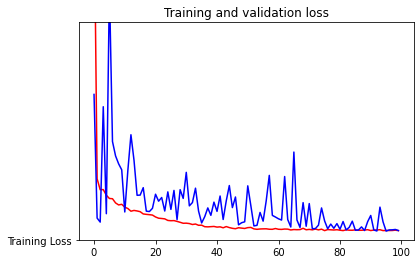

In [842]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_6featuresbi3lstm_msft=history_6featuresbi3lstm_msft.history['loss']
val_loss_6featuresbi3lstm_msft=history_6featuresbi3lstm_msft.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_6featuresbi3lstm_msft, 'r', "Training Loss")
plt.plot(epochs, val_loss_6featuresbi3lstm_msft, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [843]:
X_test_6features_msft,y_test_6features_msft=making_test(test_sc,20)
y_pred_6featuresbi3lstm_msft=making_y_pred(model_6featuresbi3lstm_msft,X_test_6features_msft)
mse_6featuresbi3lstm_msft,rmse_6featuresbi3lstm_msft,r_6featuresbi3lstm_msft=Eval(model_6featuresbi3lstm_msft,X_test_6features_msft,y_test_6features_msft,y_pred_6featuresbi3lstm_msft)

MSE: 0.003492846754362644  RMSE: 0.059100310949796564 R^2 score: 0.9624352200634011


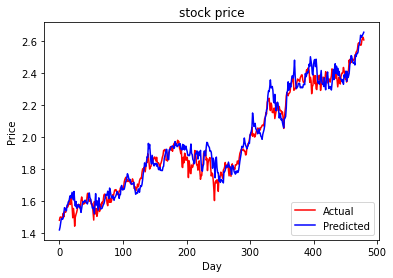

In [844]:
testset_plot(y_test_6features_msft,y_pred_6featuresbi3lstm_msft)

#### NVDA

In [845]:
df_nvda=pd.read_csv("NVDA_indicators.csv")
df_nvda_picked = df_nvda[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20

train_sc,val_sc,test_sc=making_scaled_training_val_test_data(df_nvda_picked,1500,4500,5000,5495)
X_train_6features_nvda,y_train_6features_nvda,X_val_6features_nvda,y_val_6features_nvda=making_train_val(train_sc,val_sc,windows_size)

In [846]:
model_6featuresbi3lstm_nvda =tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_6featuresbi3lstm_nvda.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_6featuresbi3lstm_nvda = model_6featuresbi3lstm_nvda.fit(X_train_6features_nvda,y_train_6features_nvda, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 2s 22ms/step - loss: 0.0222 - mae: 0.1593
Epoch 2/100
94/94 [==============================] - 2s 21ms/step - loss: 0.0172 - mae: 0.1297
Epoch 3/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0127 - mae: 0.0999
Epoch 4/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0091 - mae: 0.0774
Epoch 5/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0068 - mae: 0.0687
Epoch 6/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0054 - mae: 0.0678
Epoch 7/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0047 - mae: 0.0648
Epoch 8/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0038 - mae: 0.0591
Epoch 9/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0029 - mae: 0.0511
Epoch 10/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0018 - mae: 0.0405
Epoch 11/100
94/94 [=============================

94/94 [==============================] - 2s 19ms/step - loss: 0.0102 - mae: 0.0937
Epoch 84/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0111 - mae: 0.1008
Epoch 85/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0111 - mae: 0.1005
Epoch 86/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0121 - mae: 0.1072
Epoch 87/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0155 - mae: 0.1279
Epoch 88/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0121 - mae: 0.1077
Epoch 89/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0157 - mae: 0.1314
Epoch 90/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0216 - mae: 0.1579
Epoch 91/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0192 - mae: 0.1447
Epoch 92/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0140 - mae: 0.1190
Epoch 93/100
94/94 [==============================] -

(1e-05, 10.0, 0.0, 0.011)

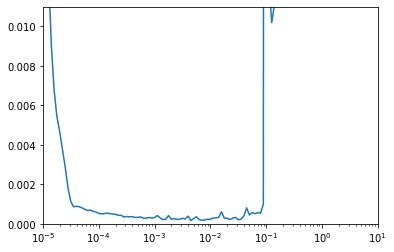

In [847]:
plt.semilogx(history_6featuresbi3lstm_nvda.history["lr"], history_6featuresbi3lstm_nvda.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [848]:
model_6featuresbi3lstm_nvda =tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_6featuresbi3lstm_nvda.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_6featuresbi3lstm_nvda = model_6featuresbi3lstm_nvda.fit(X_train_6features_nvda,y_train_6features_nvda,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_6features_nvda, y_val_6features_nvda),verbose = 1)

Epoch 1/100
47/47 [==============================] - 2s 47ms/step - loss: 0.0045 - val_loss: 0.5924
Epoch 2/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0011 - val_loss: 0.7743
Epoch 3/100
47/47 [==============================] - 1s 23ms/step - loss: 9.6556e-04 - val_loss: 0.7004
Epoch 4/100
47/47 [==============================] - 1s 23ms/step - loss: 7.6232e-04 - val_loss: 0.5228
Epoch 5/100
47/47 [==============================] - 1s 23ms/step - loss: 8.4320e-04 - val_loss: 0.7804
Epoch 6/100
47/47 [==============================] - 1s 23ms/step - loss: 7.3285e-04 - val_loss: 0.6237
Epoch 7/100
47/47 [==============================] - 1s 23ms/step - loss: 7.3670e-04 - val_loss: 0.7413
Epoch 8/100
47/47 [==============================] - 1s 23ms/step - loss: 6.7812e-04 - val_loss: 0.5108
Epoch 9/100
47/47 [==============================] - 1s 22ms/step - loss: 6.4855e-04 - val_loss: 0.5777
Epoch 10/100
47/47 [==============================] - 1s 23ms/step - los

47/47 [==============================] - 1s 22ms/step - loss: 2.5115e-04 - val_loss: 0.2332
Epoch 80/100
47/47 [==============================] - 1s 22ms/step - loss: 2.6686e-04 - val_loss: 0.2424
Epoch 81/100
47/47 [==============================] - 1s 22ms/step - loss: 2.3758e-04 - val_loss: 0.2240
Epoch 82/100
47/47 [==============================] - 1s 22ms/step - loss: 2.1684e-04 - val_loss: 0.2297
Epoch 83/100
47/47 [==============================] - 1s 22ms/step - loss: 2.5973e-04 - val_loss: 0.2170
Epoch 84/100
47/47 [==============================] - 1s 22ms/step - loss: 2.3478e-04 - val_loss: 0.2030
Epoch 85/100
47/47 [==============================] - 1s 22ms/step - loss: 2.2140e-04 - val_loss: 0.1895
Epoch 86/100
47/47 [==============================] - 1s 22ms/step - loss: 3.0441e-04 - val_loss: 0.1801
Epoch 87/100
47/47 [==============================] - 1s 22ms/step - loss: 2.7661e-04 - val_loss: 0.2909
Epoch 88/100
47/47 [==============================] - 1s 22ms/step -

In [849]:
model_6featuresbi3lstm_nvda.summary()

Model: "sequential_166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_75 (Bidirectio (None, 20, 12)            624       
_________________________________________________________________
bidirectional_76 (Bidirectio (None, 20, 80)            16960     
_________________________________________________________________
lstm_317 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_118 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_142 (Dense)            (None, 1)                 41        
Total params: 36,985
Trainable params: 36,985
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

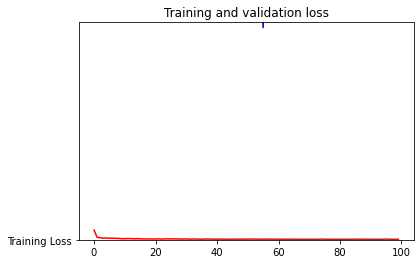

In [850]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_6featuresbi3lstm_nvda=history_6featuresbi3lstm_nvda.history['loss']
val_loss_6featuresbi3lstm_nvda=history_6featuresbi3lstm_nvda.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_6featuresbi3lstm_nvda, 'r', "Training Loss")
plt.plot(epochs, val_loss_6featuresbi3lstm_nvda, 'b', "Validation Loss")
plt.ylim([0,0.1])

plt.title('Training and validation loss')

In [851]:
X_test_6features_nvda,y_test_6features_nvda=making_test(test_sc,20)
y_pred_6featuresbi3lstm_nvda=making_y_pred(model_6featuresbi3lstm_nvda,X_test_6features_nvda)
mse_6featuresbi3lstm_nvda,rmse_6featuresbi3lstm_nvda,r_6featuresbi3lstm_nvda=Eval(model_6featuresbi3lstm_nvda,X_test_6features_nvda,y_test_6features_nvda,y_pred_6featuresbi3lstm_nvda)

MSE: 2.583541093669427  RMSE: 1.6073397567625294 R^2 score: -0.20296309107368837


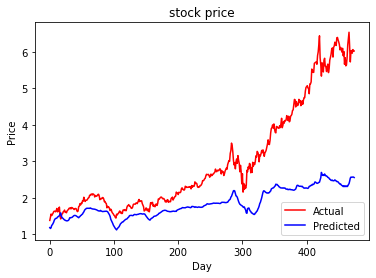

In [852]:
testset_plot(y_test_6features_nvda,y_pred_6featuresbi3lstm_nvda)

#### Macys

In [853]:
df=pd.read_csv('M.csv')

In [854]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1992-02-05,9.1250,9.1250,8.2500,8.6250,5.318645,11325800
1,1992-02-06,8.6250,8.6250,8.3750,8.4375,5.203022,5696400
2,1992-02-07,8.4375,8.4375,7.8125,7.8125,4.817612,1698000
3,1992-02-10,7.8750,7.8750,7.5000,7.5625,4.663449,1104400
4,1992-02-11,7.5625,7.6875,7.5625,7.6875,4.740532,656200
...,...,...,...,...,...,...,...
7249,2020-11-13,7.0700,7.3800,6.9700,7.3600,7.360000,25190200
7250,2020-11-16,7.8800,8.0400,7.4200,8.0200,8.020000,38710200
7251,2020-11-17,7.8900,8.8800,7.7400,8.8000,8.800000,51175200
7252,2020-11-18,8.9400,9.2600,8.6900,8.9900,8.990000,49088400


In [855]:
Highlow_Openclose(df)
MA(df,7)
MA(df,14)
MA(df,21)
std_dev(df,7)
EMA(df,10)
EMA(df,20)
RSI(df)   
MACD(df)

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [856]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,10 DAYS EMA,20 DAYS EMA,RSI,MACD
0,1992-02-05,9.1250,9.1250,8.2500,8.6250,5.318645,11325800,0.875000,-0.5000,0.000000,0.000000,0.000000,0.000000,8.625000,8.625000,NaN,0.000000
1,1992-02-06,8.6250,8.6250,8.3750,8.4375,5.203022,5696400,0.250000,-0.1875,0.000000,0.000000,0.000000,0.000000,8.590909,8.607143,NaN,-0.014957
2,1992-02-07,8.4375,8.4375,7.8125,7.8125,4.817612,1698000,0.625000,-0.6250,0.000000,0.000000,0.000000,0.000000,8.449380,8.531463,NaN,-0.076363
3,1992-02-10,7.8750,7.8750,7.5000,7.5625,4.663449,1104400,0.375000,-0.3125,0.000000,0.000000,0.000000,0.000000,8.288129,8.439180,NaN,-0.143546
4,1992-02-11,7.5625,7.6875,7.5625,7.6875,4.740532,656200,0.125000,0.1250,0.000000,0.000000,0.000000,0.000000,8.178924,8.367592,NaN,-0.184574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,2020-11-13,7.0700,7.3800,6.9700,7.3600,7.360000,25190200,0.410000,0.2900,7.017143,6.679286,6.625714,0.740349,7.027932,6.789741,47.297295,0.247888
7250,2020-11-16,7.8800,8.0400,7.4200,8.0200,8.020000,38710200,0.620000,0.1400,7.174286,6.722857,6.677619,0.750975,7.208308,6.906908,57.043881,0.313748
7251,2020-11-17,7.8900,8.8800,7.7400,8.8000,8.800000,51175200,1.140000,0.9100,7.400000,6.835000,6.766191,0.813683,7.497706,7.087203,66.737745,0.423994
7252,2020-11-18,8.9400,9.2600,8.6900,8.9900,8.990000,49088400,0.570001,0.0500,7.718571,7.027143,6.894762,0.963962,7.769033,7.268422,76.218321,0.520694


In [857]:

df_M_picked = df[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']] # Picking the features with high correlation

train_start = 1000
train_end = 6000
train_data = df_M_picked.loc[train_start:train_end-1]

val_start = 6000
val_end = 6500
val_data = df_M_picked.loc[val_start:val_end-1]

test_start = 6500
test_end = 7254
test_data = df_M_picked.loc[test_start:test_end-1]

print(train_data.shape,val_data.shape,test_data.shape)

windows_size=20

sc = MinMaxScaler()
train_sc = sc.fit_transform(train_data)
val_sc = sc.transform(val_data)
test_sc = sc.transform(test_data)  

(5000, 6) (500, 6) (754, 6)


In [858]:
X_train,y_train,X_val,y_val=making_train_val(train_sc,val_sc,windows_size)

In [859]:
model_m =tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_m.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_m = model_m.fit(X_train,y_train,epochs = 100 ,batch_size = 64 ,validation_data = (X_val, y_val),verbose = 1)

Epoch 1/100
78/78 [==============================] - 3s 38ms/step - loss: 0.0127 - val_loss: 0.0014
Epoch 2/100
78/78 [==============================] - 2s 23ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/100
78/78 [==============================] - 2s 23ms/step - loss: 0.0017 - val_loss: 9.5873e-04
Epoch 4/100
78/78 [==============================] - 2s 23ms/step - loss: 0.0016 - val_loss: 9.8289e-04
Epoch 5/100
78/78 [==============================] - 2s 22ms/step - loss: 0.0015 - val_loss: 9.7352e-04
Epoch 6/100
78/78 [==============================] - 2s 22ms/step - loss: 0.0014 - val_loss: 8.6336e-04
Epoch 7/100
78/78 [==============================] - 2s 22ms/step - loss: 0.0014 - val_loss: 8.3150e-04
Epoch 8/100
78/78 [==============================] - 2s 22ms/step - loss: 0.0013 - val_loss: 7.4396e-04
Epoch 9/100
78/78 [==============================] - 2s 22ms/step - loss: 0.0013 - val_loss: 8.7239e-04
Epoch 10/100
78/78 [==============================] - 2s 22ms/step - los

Epoch 77/100
78/78 [==============================] - 2s 22ms/step - loss: 4.4324e-04 - val_loss: 2.6165e-04
Epoch 78/100
78/78 [==============================] - 2s 22ms/step - loss: 4.4095e-04 - val_loss: 2.7727e-04
Epoch 79/100
78/78 [==============================] - 2s 22ms/step - loss: 4.4642e-04 - val_loss: 2.8908e-04
Epoch 80/100
78/78 [==============================] - 2s 22ms/step - loss: 4.7853e-04 - val_loss: 3.5764e-04
Epoch 81/100
78/78 [==============================] - 2s 22ms/step - loss: 4.5047e-04 - val_loss: 2.9537e-04
Epoch 82/100
78/78 [==============================] - 2s 22ms/step - loss: 4.6857e-04 - val_loss: 2.5104e-04
Epoch 83/100
78/78 [==============================] - 2s 22ms/step - loss: 4.2337e-04 - val_loss: 2.7829e-04
Epoch 84/100
78/78 [==============================] - 2s 22ms/step - loss: 4.3387e-04 - val_loss: 2.5838e-04
Epoch 85/100
78/78 [==============================] - 2s 22ms/step - loss: 4.5155e-04 - val_loss: 2.7598e-04
Epoch 86/100
78/78 

In [860]:
X_test_m = []
y_test_m= []

for i in range(windows_size,test_sc.shape[0]):
    X_test_m.append(test_sc[i-windows_size:i])
    y_test_m.append(test_sc[i][0])
X_test_m,y_test_m = np.array(X_test_m),np.array(y_test_m)

In [861]:
y_pred_m = model_m.predict(X_test_m)
y_pred_m=y_pred_m.ravel()

In [862]:
mse_m = mean_squared_error(y_test_m,y_pred_m)
rmse_m = sqrt(mse_m)
r_m = r2_score(y_test_m,y_pred_m)
print('MSE:',mse_m,' RMSE:',rmse_m, 'R^2 score:',r_m)

MSE: 0.0003682644521806122  RMSE: 0.019190217616812277 R^2 score: 0.9853708734200847


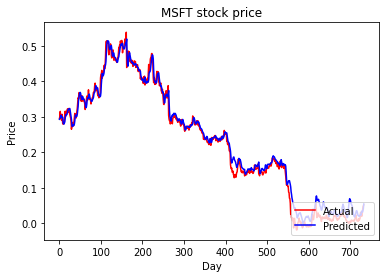

In [863]:
plt.plot(y_test_m,c = 'r')
plt.plot(y_pred_m,c = 'b')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('MSFT stock price')
plt.legend(['Actual','Predicted'],loc = 'lower right')
plt.show()

### conv1d + 3 lstm 

#### AMD

In [879]:
df_AMD=pd.read_csv("AMD_indicators.csv")
df_AMD_picked = df_AMD[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_6features_amd,y_train_6features_amd,X_val_6features_amd,y_val_6features_amd=making_train_val(train_sc,val_sc,windows_size)

In [865]:
model_conv1d_6featuresbi3lstm_amd = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_conv1d_6featuresbi3lstm_amd.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_conv1d_6featuresbi3lstm_amd = model_conv1d_6featuresbi3lstm_amd.fit(X_train_6features_amd,y_train_6features_amd, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0274 - mae: 0.1756
Epoch 2/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0157 - mae: 0.1244
Epoch 3/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0073 - mae: 0.0838
Epoch 4/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0037 - mae: 0.0638
Epoch 5/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0027 - mae: 0.0559
Epoch 6/100
140/140 [==============================] - 2s 15ms/step - loss: 0.0023 - mae: 0.0502
Epoch 7/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0021 - mae: 0.0462
Epoch 8/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0019 - mae: 0.0428
Epoch 9/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0017 - mae: 0.0407
Epoch 10/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0015 - mae: 0.0376
Epoch 11/100
140/140 [=======

140/140 [==============================] - 2s 13ms/step - loss: 6.6731e-04 - mae: 0.0261
Epoch 83/100
140/140 [==============================] - 2s 13ms/step - loss: 8.9669e-04 - mae: 0.0306
Epoch 84/100
140/140 [==============================] - 2s 13ms/step - loss: 8.4052e-04 - mae: 0.0299
Epoch 85/100
140/140 [==============================] - 2s 13ms/step - loss: 9.6322e-04 - mae: 0.0309
Epoch 86/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0014 - mae: 0.0384
Epoch 87/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0071 - mae: 0.0712
Epoch 88/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0209 - mae: 0.1563
Epoch 89/100
140/140 [==============================] - 2s 14ms/step - loss: 0.0211 - mae: 0.1568
Epoch 90/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0201 - mae: 0.1538
Epoch 91/100
140/140 [==============================] - 2s 13ms/step - loss: 0.0198 - mae: 0.1526
Epoch 92/100
140/

(1e-05, 10.0, 0.0, 0.011)

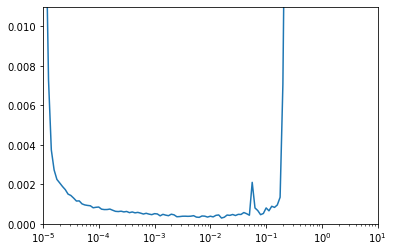

In [866]:
plt.semilogx(history_conv1d_6featuresbi3lstm_amd.history["lr"], history_conv1d_6featuresbi3lstm_amd.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [867]:
model_conv1d_6featuresbi3lstm_amd = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_conv1d_6featuresbi3lstm_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_conv1d_6featuresbi3lstm_amd = model_conv1d_6featuresbi3lstm_amd.fit(X_train_6features_amd,y_train_6features_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_6features_amd, y_val_6features_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 3s 43ms/step - loss: 0.0111 - val_loss: 8.2315e-04
Epoch 2/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0018 - val_loss: 9.0045e-04
Epoch 3/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 5.8126e-04
Epoch 4/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 7.1972e-04
Epoch 5/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 3.7565e-04
Epoch 6/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 3.9369e-04
Epoch 7/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 2.9239e-04
Epoch 8/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 3.0920e-04
Epoch 9/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0010 - val_loss: 2.7619e-04
Epoch 10/100
70/70 [==============================] - 1s 16ms/st

70/70 [==============================] - 1s 16ms/step - loss: 5.1204e-04 - val_loss: 1.3855e-04
Epoch 77/100
70/70 [==============================] - 1s 16ms/step - loss: 5.2279e-04 - val_loss: 1.7816e-04
Epoch 78/100
70/70 [==============================] - 1s 16ms/step - loss: 4.8903e-04 - val_loss: 1.1508e-04
Epoch 79/100
70/70 [==============================] - 1s 16ms/step - loss: 4.8968e-04 - val_loss: 9.3961e-05
Epoch 80/100
70/70 [==============================] - 1s 16ms/step - loss: 4.8342e-04 - val_loss: 9.6930e-05
Epoch 81/100
70/70 [==============================] - 1s 16ms/step - loss: 4.9564e-04 - val_loss: 8.9310e-05
Epoch 82/100
70/70 [==============================] - 1s 16ms/step - loss: 4.8234e-04 - val_loss: 1.2870e-04
Epoch 83/100
70/70 [==============================] - 1s 16ms/step - loss: 5.1585e-04 - val_loss: 1.5107e-04
Epoch 84/100
70/70 [==============================] - 1s 16ms/step - loss: 4.3778e-04 - val_loss: 9.1852e-05
Epoch 85/100
70/70 [============

In [868]:
model_conv1d_6featuresbi3lstm_amd.summary()

Model: "sequential_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_81 (Bidirectio (None, 20, 12)            624       
_________________________________________________________________
bidirectional_82 (Bidirectio (None, 20, 80)            16960     
_________________________________________________________________
lstm_326 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_121 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 41        
Total params: 36,985
Trainable params: 36,985
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

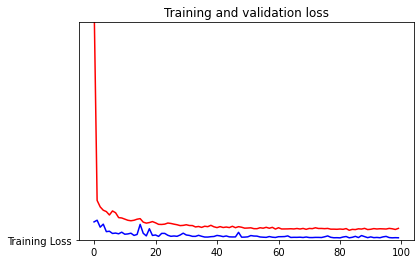

In [869]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_conv1d_6featuresbi_amd=history_conv1d_6featuresbi3lstm_amd.history['loss']
val_loss_conv1d_6featuresbi_amd=history_conv1d_6featuresbi3lstm_amd.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_conv1d_6featuresbi_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_conv1d_6featuresbi_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [885]:
X_test_6features_amd,y_test_6features_amd=making_test(test_sc,20)
y_pred_conv1d_6featuresbi3lstm_amd=making_y_pred(model_conv1d_6featuresbi3lstm_amd,X_test_conv1d_6featuresbi3lstm_amd)
mse_conv1d_6featuresbi3lstm_amd,rmse_conv1d_6featuresbi3lstm_amd,r_conv1d_6featuresbi3lstm_amd=Eval(model_conv1d_6featuresbi3lstm_amd,X_test_6features_amd,y_test_6features_amd,y_pred_conv1d_6featuresbi3lstm_amd)

MSE: 0.00045088398719572877  RMSE: 0.021234028991120098 R^2 score: 0.9841863155892291


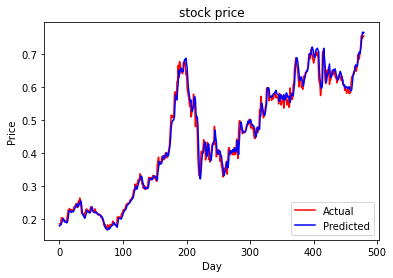

In [891]:
testset_plot(y_test_6features_amd,y_pred_conv1d_6featuresbi3lstm_amd)

#### MSFT

In [892]:
df_msft=pd.read_csv("msft_indicators.csv")
df_msft_picked = df_msft[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_msft_picked,2000,7500,8000,8500)
X_train_6features_msft,y_train_6features_msft,X_val_6features_msft,y_val_6features_msft=making_train_val(train_sc,val_sc,windows_size)

In [893]:
model_conv1d_6featuresbi3lstm_msft = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_conv1d_6featuresbi3lstm_msft.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_conv1d_6featuresbi3lstm_msft = model_conv1d_6featuresbi3lstm_msft.fit(X_train_6features_msft,y_train_6features_msft, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 4s 23ms/step - loss: 0.1284 - mae: 0.4673
Epoch 2/100
172/172 [==============================] - 4s 22ms/step - loss: 0.0871 - mae: 0.3733
Epoch 3/100
172/172 [==============================] - 4s 21ms/step - loss: 0.0444 - mae: 0.2581
Epoch 4/100
172/172 [==============================] - 4s 21ms/step - loss: 0.0158 - mae: 0.1425
Epoch 5/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0079 - mae: 0.0974
Epoch 6/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0047 - mae: 0.0735
Epoch 7/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0038 - mae: 0.0658
Epoch 8/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0033 - mae: 0.0610
Epoch 9/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0029 - mae: 0.0579
Epoch 10/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0026 - mae: 0.0542
Epoch 11/100
172/172 [=======

172/172 [==============================] - 3s 20ms/step - loss: 6.9292e-04 - mae: 0.0272
Epoch 81/100
172/172 [==============================] - 3s 20ms/step - loss: 6.1968e-04 - mae: 0.0262: 1s - loss
Epoch 82/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0737 - mae: 0.1622
Epoch 83/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0284 - mae: 0.1800
Epoch 84/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0240 - mae: 0.1668
Epoch 85/100
172/172 [==============================] - 3s 19ms/step - loss: 0.0249 - mae: 0.1735
Epoch 86/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0240 - mae: 0.1673
Epoch 87/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0257 - mae: 0.1733
Epoch 88/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0261 - mae: 0.1773
Epoch 89/100
172/172 [==============================] - 3s 20ms/step - loss: 0.0317 - mae: 0.1990
Epoch 90/100
1

(1e-05, 10.0, 0.0, 0.011)

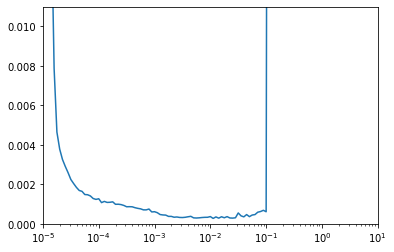

In [894]:
plt.semilogx(history_conv1d_6featuresbi3lstm_msft.history["lr"], history_conv1d_6featuresbi3lstm_msft.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [895]:
model_conv1d_6featuresbi3lstm_msft = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_conv1d_6featuresbi3lstm_msft.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_conv1d_6featuresbi3lstm_msft = model_conv1d_6featuresbi3lstm_msft.fit(X_train_6features_msft,y_train_6features_msft,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_6features_msft, y_val_6features_msft),verbose = 1)

Epoch 1/100
86/86 [==============================] - 11s 134ms/step - loss: 0.0198 - val_loss: 0.0042
Epoch 2/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 3/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0022 - val_loss: 0.0077
Epoch 4/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 5/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 6/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0018 - val_loss: 0.0079
Epoch 7/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0018 - val_loss: 0.0096
Epoch 8/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 9/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0016 - val_loss: 0.0096
Epoch 10/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0016 - val_loss: 0.00

86/86 [==============================] - 2s 23ms/step - loss: 4.3091e-04 - val_loss: 7.3796e-04
Epoch 80/100
86/86 [==============================] - 2s 23ms/step - loss: 4.3042e-04 - val_loss: 5.2408e-04
Epoch 81/100
86/86 [==============================] - 2s 23ms/step - loss: 4.5140e-04 - val_loss: 6.1825e-04
Epoch 82/100
86/86 [==============================] - 2s 23ms/step - loss: 4.8312e-04 - val_loss: 0.0014
Epoch 83/100
86/86 [==============================] - 2s 23ms/step - loss: 4.6059e-04 - val_loss: 5.2264e-04
Epoch 84/100
86/86 [==============================] - 2s 23ms/step - loss: 4.7923e-04 - val_loss: 7.2359e-04
Epoch 85/100
86/86 [==============================] - 2s 23ms/step - loss: 4.6633e-04 - val_loss: 0.0011
Epoch 86/100
86/86 [==============================] - 2s 22ms/step - loss: 4.4248e-04 - val_loss: 5.1313e-04
Epoch 87/100
86/86 [==============================] - 2s 23ms/step - loss: 4.3799e-04 - val_loss: 3.5251e-04
Epoch 88/100
86/86 [====================

In [896]:
model_conv1d_6featuresbi3lstm_msft.summary()

Model: "sequential_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_85 (Bidirectio (None, 20, 12)            624       
_________________________________________________________________
bidirectional_86 (Bidirectio (None, 20, 80)            16960     
_________________________________________________________________
lstm_332 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_123 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 41        
Total params: 36,985
Trainable params: 36,985
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

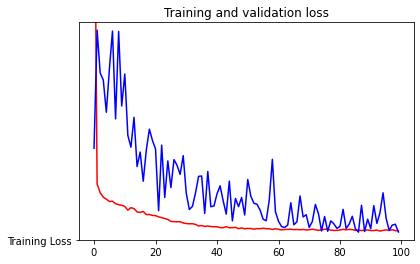

In [897]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_conv1d_6featuresbi_msft=history_conv1d_6featuresbi3lstm_msft.history['loss']
val_loss_conv1d_6featuresbi_msft=history_conv1d_6featuresbi3lstm_msft.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_conv1d_6featuresbi_msft, 'r', "Training Loss")
plt.plot(epochs, val_loss_conv1d_6featuresbi_msft, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [899]:
X_test_6features_msft,y_test_6features_msft=making_test(test_sc,20)
y_pred_conv1d_6featuresbi3lstm_msft=making_y_pred(model_conv1d_6featuresbi3lstm_msft,X_test_6features_msft)
mse_conv1d_6featuresbi3lstm_msft,rmse_conv1d_6featuresbi3lstm_msft,r_conv1d_6featuresbi3lstm_msft=Eval(model_conv1d_6featuresbi3lstm_msft,X_test_6features_msft,y_test_6features_msft,y_pred_conv1d_6featuresbi3lstm_msft)

MSE: 0.017427701025870476  RMSE: 0.13201401829302248 R^2 score: 0.8125690017691249


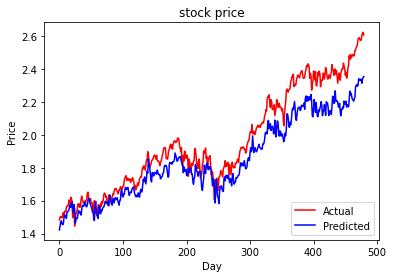

In [901]:
testset_plot(y_test_6features_msft,y_pred_conv1d_6featuresbi3lstm_msft)

#### NVDA

In [902]:
df_nvda=pd.read_csv("nvda_indicators.csv")
df_nvda_picked = df_nvda[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']]
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_nvda_picked,1500,4500,5000,5495)
X_train_6features_nvda,y_train_6features_nvda,X_val_6features_nvda,y_val_6features_nvda=making_train_val(train_sc,val_sc,windows_size)

In [903]:
model_conv1d_6featuresbi3lstm_nvda = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_conv1d_6featuresbi3lstm_nvda.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_conv1d_6featuresbi3lstm_nvda = model_conv1d_6featuresbi3lstm_nvda.fit(X_train_6features_nvda,y_train_6features_nvda, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 2s 22ms/step - loss: 0.0540 - mae: 0.2867
Epoch 2/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0333 - mae: 0.2116
Epoch 3/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0195 - mae: 0.1426
Epoch 4/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0117 - mae: 0.0932
Epoch 5/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0080 - mae: 0.0758
Epoch 6/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0072 - mae: 0.0778
Epoch 7/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0067 - mae: 0.0758
Epoch 8/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0062 - mae: 0.0745
Epoch 9/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0060 - mae: 0.0713
Epoch 10/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0055 - mae: 0.0695
Epoch 11/100
94/94 [=============================

94/94 [==============================] - 2s 19ms/step - loss: 0.0096 - mae: 0.0894
Epoch 84/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0106 - mae: 0.0971
Epoch 85/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0101 - mae: 0.0928
Epoch 86/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0097 - mae: 0.0894
Epoch 87/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0097 - mae: 0.0905
Epoch 88/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0098 - mae: 0.0925
Epoch 89/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0100 - mae: 0.0927
Epoch 90/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0102 - mae: 0.0941
Epoch 91/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0109 - mae: 0.1013
Epoch 92/100
94/94 [==============================] - 2s 20ms/step - loss: 0.0112 - mae: 0.1022
Epoch 93/100
94/94 [==============================] -

(1e-05, 10.0, 0.0, 0.011)

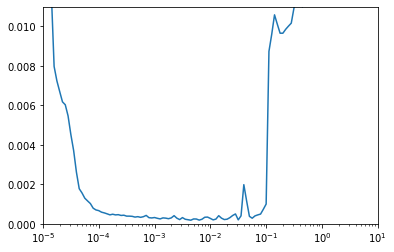

In [904]:
plt.semilogx(history_conv1d_6featuresbi3lstm_nvda.history["lr"], history_conv1d_6featuresbi3lstm_nvda.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [905]:
model_conv1d_6featuresbi3lstm_nvda = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,6),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_conv1d_6featuresbi3lstm_nvda.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'mean_squared_error')

history_conv1d_6featuresbi3lstm_nvda = model_conv1d_6featuresbi3lstm_nvda.fit(X_train_6features_nvda,y_train_6features_nvda,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_6features_nvda, y_val_6features_nvda),verbose = 1)

Epoch 1/100
47/47 [==============================] - 2s 47ms/step - loss: 0.0110 - val_loss: 0.2055
Epoch 2/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0012 - val_loss: 0.4531
Epoch 3/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0011 - val_loss: 0.4761
Epoch 4/100
47/47 [==============================] - 1s 23ms/step - loss: 7.8156e-04 - val_loss: 0.4187
Epoch 5/100
47/47 [==============================] - 1s 23ms/step - loss: 6.8892e-04 - val_loss: 0.3498
Epoch 6/100
47/47 [==============================] - 1s 23ms/step - loss: 7.1898e-04 - val_loss: 0.2680
Epoch 7/100
47/47 [==============================] - 1s 23ms/step - loss: 7.2215e-04 - val_loss: 0.2694
Epoch 8/100
47/47 [==============================] - 1s 23ms/step - loss: 6.9631e-04 - val_loss: 0.2045
Epoch 9/100
47/47 [==============================] - 1s 22ms/step - loss: 5.5515e-04 - val_loss: 0.2893
Epoch 10/100
47/47 [==============================] - 1s 23ms/step - loss: 6

47/47 [==============================] - 1s 22ms/step - loss: 2.4471e-04 - val_loss: 0.5174
Epoch 80/100
47/47 [==============================] - 1s 22ms/step - loss: 2.6087e-04 - val_loss: 0.4884
Epoch 81/100
47/47 [==============================] - 1s 22ms/step - loss: 2.8630e-04 - val_loss: 0.4509
Epoch 82/100
47/47 [==============================] - 1s 22ms/step - loss: 2.8225e-04 - val_loss: 0.4758
Epoch 83/100
47/47 [==============================] - 1s 22ms/step - loss: 2.3583e-04 - val_loss: 0.5027
Epoch 84/100
47/47 [==============================] - 1s 22ms/step - loss: 2.4959e-04 - val_loss: 0.5170
Epoch 85/100
47/47 [==============================] - 1s 22ms/step - loss: 2.4240e-04 - val_loss: 0.5126
Epoch 86/100
47/47 [==============================] - 1s 22ms/step - loss: 2.5782e-04 - val_loss: 0.5140
Epoch 87/100
47/47 [==============================] - 1s 22ms/step - loss: 2.4895e-04 - val_loss: 0.4961
Epoch 88/100
47/47 [==============================] - 1s 22ms/step -

In [906]:
model_conv1d_6featuresbi3lstm_nvda.summary()

Model: "sequential_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_89 (Bidirectio (None, 20, 12)            624       
_________________________________________________________________
bidirectional_90 (Bidirectio (None, 20, 80)            16960     
_________________________________________________________________
lstm_338 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_125 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 41        
Total params: 36,985
Trainable params: 36,985
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

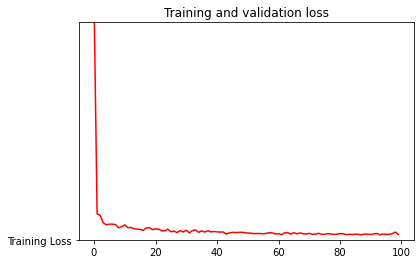

In [907]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_conv1d_6featuresbi_nvda=history_conv1d_6featuresbi3lstm_nvda.history['loss']
val_loss_conv1d_6featuresbi_nvda=history_conv1d_6featuresbi3lstm_nvda.history['val_loss']

epochs=range(len(loss)) 


plt.plot(epochs, loss_conv1d_6featuresbi_nvda, 'r', "Training Loss")
plt.plot(epochs, val_loss_conv1d_6featuresbi_nvda, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [908]:
X_test_6features_nvda,y_test_6features_nvda=making_test(test_sc,20)
y_pred_conv1d_6featuresbi3lstm_nvda=making_y_pred(model_conv1d_6featuresbi3lstm_nvda,X_test_6features_nvda)
mse_conv1d_6featuresbi3lstm_nvda,rmse_conv1d_6featuresbi3lstm_nvda,r_conv1d_6featuresbi3lstm_nvda=Eval(model_conv1d_6featuresbi3lstm_nvda,X_test_6features_nvda,y_test_6features_nvda,y_pred_conv1d_6featuresbi3lstm_nvda)

MSE: 3.144501025665023  RMSE: 1.773274097725736 R^2 score: -0.4641604435816229


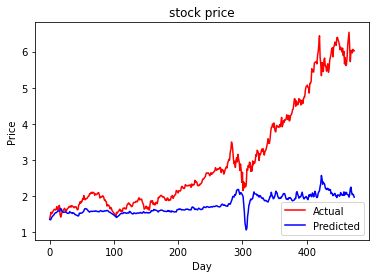

In [909]:
testset_plot(y_test_6features_nvda,y_pred_conv1d_6featuresbi3lstm_nvda)